In [1]:
# Data
import pandas as pd
import numpy as np
import random
import gc


# Visualization
import folium
import matplotlib
matplotlib.rcParams.update({'font.size': 30})
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.5)
sns.set(rc={'figure.figsize':(15,5)})
from matplotlib.patches import Patch
cmap_cv = plt.cm.coolwarm

# Machine learning
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KernelKMeans
from sklearn.metrics import roc_auc_score, f1_score, precision_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import lightgbm as lgb
from sklearn import metrics



# Do not disturb
import warnings
warnings.filterwarnings('ignore')

## 0. Key questions

Some of the key questions we could try to answer are:

1. Has the frequency of heat waves events increased over the last years? $\newline$
2. Is there any relationship between heat waves and peak flow events? $\newline$
3. If so, can we correlate those events with the watershed's features? $\newline$

The objective of the EDA is to study the data and extract meaningful insights from wich would be possible to gather information in order to answer these quiestions.

## 1. Load .csv

Load the .csv and check if the column date is in a correct format.

In [2]:
flux = pd.read_csv('flux.csv')
flux['date'] = pd.to_datetime(flux['date'], errors = 'raise')
flux.head(2)

date  basin_id   flux  precip   temp_max                 gauge_name  \
0 1980-01-01   1001001  0.579     0.0  10.685653  Rio Caquena En Nacimiento   
1 1980-01-02   1001001  0.543     0.0  11.470960  Rio Caquena En Nacimiento   

       lat      lon    mean_elev   area_km2  
0 -18.0769 -69.1961  4842.449328  49.711859  
1 -18.0769 -69.1961  4842.449328  49.711859

## 2. EDA

### 2.1 Descriptive statistics

There are 503 different stations.

In [3]:
len(flux['basin_id'].unique())

503

The date range is form 1980/01/01 to 2020/06/06.

In [4]:
flux['date'].min(), flux['date'].max()

(Timestamp('1980-01-01 00:00:00'), Timestamp('2020-06-06 00:00:00'))

The data contains the following 10 columns:
- Observation date in timestamp format
- Variables concerning station characteristics: gauge_name, lat, lon, mean_elev, area_km2.
- Variables describing watershed conditions: flux, temp_max, precip.

In [5]:
flux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180480 entries, 0 to 4180479
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   basin_id    int64         
 2   flux        float64       
 3   precip      float64       
 4   temp_max    float64       
 5   gauge_name  object        
 6   lat         float64       
 7   lon         float64       
 8   mean_elev   float64       
 9   area_km2    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 318.9+ MB


General observations from quantiles:
1. flux: the maximum flux value difers heavily from the third quartile.
1. precip: the maximum flux value difers heavily from the third quartile.

In [6]:
flux.describe().T

count          mean           std           min           25%  \
basin_id   4180480.0  7.179757e+06  3.180965e+06  1.001001e+06  4.558001e+06   
flux       4180480.0  5.253340e+01  1.676027e+02  0.000000e+00  8.680000e-01   
precip     4175037.0  2.947445e+00  8.766749e+00  0.000000e+00  0.000000e+00   
temp_max   4175037.0  1.365728e+01  6.615037e+00 -1.160359e+01  9.162867e+00   
lat        4180480.0 -3.569572e+01  8.047659e+00 -5.494690e+01 -3.915000e+01   
lon        4180480.0 -7.129595e+01  1.254339e+00 -7.366670e+01 -7.231670e+01   
mean_elev  4180480.0  1.760129e+03  1.382121e+03  1.181229e+02  5.847012e+02   
area_km2   4180480.0  2.404876e+03  4.322051e+03  1.789123e+01  3.761001e+02   

                    50%           75%           max  
basin_id   7.350003e+06  9.416001e+06  1.293000e+07  
flux       5.171000e+00  2.990000e+01  1.580500e+04  
precip     0.000000e+00  6.422626e-01  2.132120e+02  
temp_max   1.321396e+01  1.805745e+01  4.081117e+01  
lat       -3.588420e+01 -3.126560e+01 -1.784280e+01  
lon       -7.137190e+01 -7.050670e+01 -6.763920e+01  
mean_elev  1.195311e+03  3.048161e+03  4.910152e+03  
area_km2   8.205541e+02  2.461610e+03  5.224367e+04

There are some missing values in the following columns:

In [7]:
flux.isnull().sum()

date             0
basin_id         0
flux             0
precip        5443
temp_max      5443
gauge_name       0
lat              0
lon              0
mean_elev        0
area_km2         0
dtype: int64

### 2.2 New variables for further analysis

The following variables related to time analysis are created:
1. year: year of the observation
2. month: month of the observation
3. week_number: week number of the year of the observation
4. day_number: day of the year of the observation
5. year_10: decade of the year.
6. summer: indicate if the observation date is summer season (=1) or nor (=0).

Because of Chile's geographical characteristics, weather and topographic conditions vary significantly across regions. Therefore, Chile can be divided into 3 major zones: north, center and south.$\newline$
The following variables reflect this decompostion:
1. zone: geographic zone of the observation.
2. river_id: id of the river

In [8]:
min_lat_norte = -29.910282197600495
min_lat_centro = -37.182370

flux['unique'] = 1

# Time
flux['year'] = flux['date'].dt.year
flux['month'] = flux['date'].dt.month
flux['week_number'] = flux['date'].dt.week
flux['day_number'] = flux['date'].dt.day_of_year
flux['year_10'] = flux['year'].apply(lambda x: str(x)[2] + '0')
flux['summer'] = (((flux['date'].dt.month >= 9) & (flux['date'].dt.day >=23)) | 
                  (flux['date'].dt.month >= 10) |
                  ((flux['date'].dt.month <= 3) & (flux['date'].dt.day <=20)) |
                  (flux['date'].dt.month <= 2)).astype(int)

# Geographic
flux['south'] = (flux['lat'] <= min_lat_centro).astype(int) * 1
flux['center'] = (flux['lat'] >= min_lat_centro).astype(int) * (flux['lat'] <= min_lat_norte).astype(int) * 2
flux['north'] = (flux['lat'] >= min_lat_norte).astype(int) * 3
flux['zone'] = (flux['south'] + flux['center'] + flux['north']).replace({1: 'south',
                                                                         2: 'center',
                                                                         3: 'north'})
flux['river_id'] = flux['basin_id'].apply(lambda x: int(str(x)[0:4]))

### 2.3 Missing values

There are 10,886 missing values (in the precip and temp_max columns) in 5,443 different rows.

In [9]:
len((flux[(flux['precip'].isnull()) | (flux['temp_max'].isnull())]))

5443

The missing data is found within May-2020 and June-2020. In fact, for those dates there is no available information for any station. It might be possible this is due to the COVID quarantines that began in Chile on those dates.

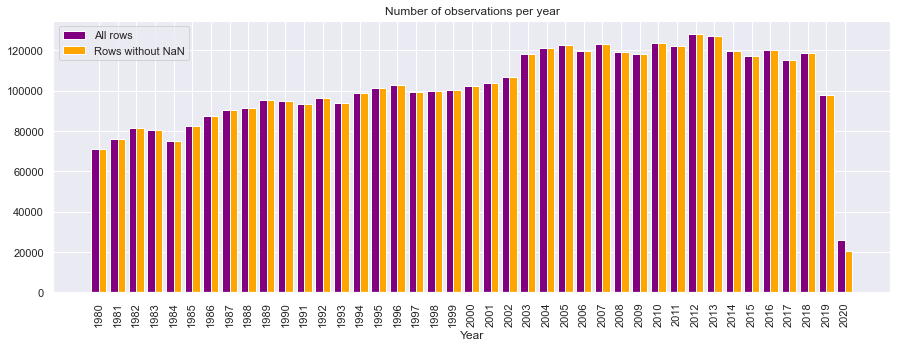

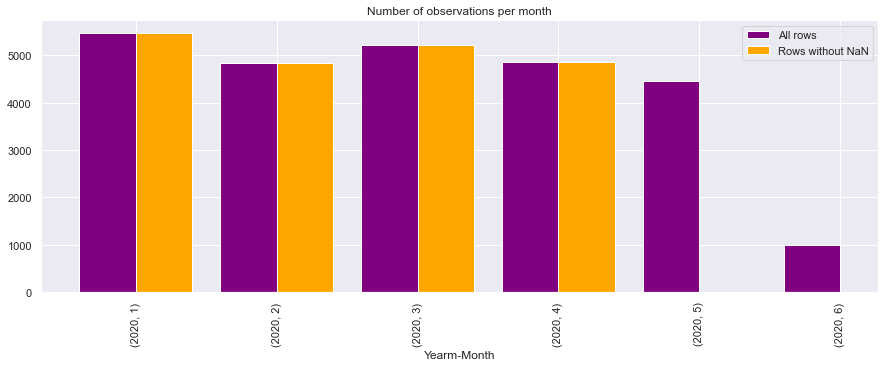

In [10]:
X = np.sort(flux['year'].value_counts().index)
X_axis = np.arange(len(X))

plt.figure(figsize=(15, 5))
plt.bar(X_axis - 0.2, flux['year'].value_counts().sort_index(), 0.4, label = 'All rows', color = 'purple')
plt.bar(X_axis + 0.2, flux[flux['precip'].isnull() == False]['year'].value_counts().sort_index(), 0.4, label = 'Rows without NaN', color = 'orange')

plt.xticks(X_axis, X, rotation = 90)
plt.xlabel("Year")
plt.ylabel("")
plt.title("Number of observations per year")
plt.legend()
plt.show()

X = np.sort(flux[flux['date'] >= pd.to_datetime('2020-01-01')][['year', 'month']].value_counts().index)
X2 = np.sort(flux[(flux['date'] >= pd.to_datetime('2020-01-01')) & (flux['precip'].isnull() == False)][['year', 'month']].value_counts().index)
X_axis = np.arange(len(X))
X2_axis = np.arange(len(X2))

plt.figure(figsize=(15, 5))
plt.bar(X_axis - 0.2, flux[flux['date'] >= pd.to_datetime('2020-01-01')][['year', 'month']].value_counts().sort_index(), 0.4, label = 'All rows', color = 'purple')
plt.bar(X2_axis + 0.2, flux[(flux['date'] >= pd.to_datetime('2020-01-01')) & (flux['precip'].isnull() == False)][['year', 'month']].value_counts().sort_index(), 0.4, label = 'Rows without NaN', color = 'orange')

plt.xticks(X_axis, X, rotation = 90)
plt.xlabel("Yearm-Month")
plt.ylabel("")
plt.title("Number of observations per month")
plt.legend()
plt.show()

It is important to mention that even when there is no other missing values in the data, although there might be days with no availbale information. Therefore it is important to check data conitnuity.

### 2.4 Data Cleaning

As there is no data for 2020-05 and 2020-06, it is not possible to make predictions for 2020-07 onwards. This is why observations later than 2020-07 are deleted. As a consequence, data now considers dates until 2020-04-30.

In [11]:
flux.dropna(inplace = True)

### 2.5 Distributions and aggregated data

#### 2.5.1 Distribution of the values of the observations
1. flux: there are some observations with a high value of flux
2. precipitations: there are some observations with a high value of flux. 
3. The north part of the country is known for having large daily temperature fluctuations: very high temperatures during the day and very low temperatures during the night. $\newline$

The center is known for having low daily temperature fluctuations: not too hot or too cold. $\newline$
The south is known for showing consistently low temperatures during the day. $\newline$
The data reflects this behaviour as the minimum temperature is -10ºC and the maximum is 40ºC.

<AxesSubplot:>

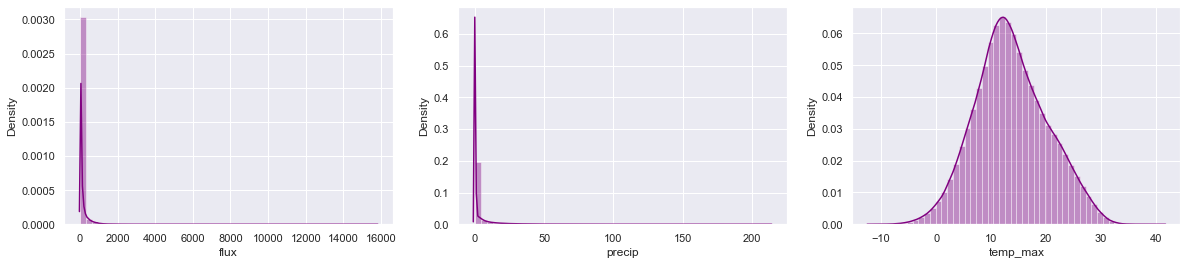

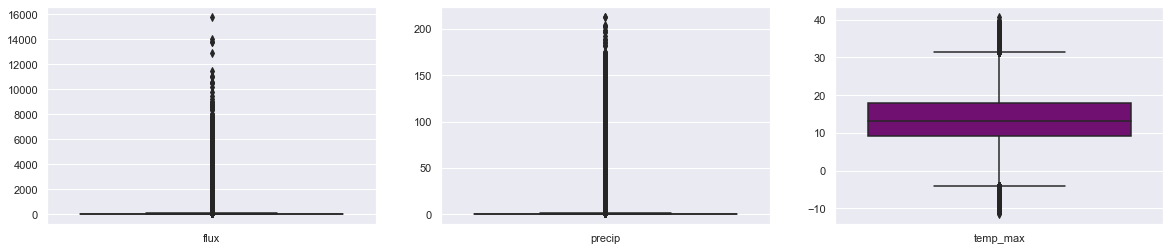

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
sns.distplot(flux['flux'], color = 'purple', ax = ax1)
sns.distplot(flux['precip'], color = 'purple', ax = ax2)
sns.distplot(flux['temp_max'], color = 'purple', ax = ax3)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
sns.boxplot(data=flux.dropna().loc[:, ['flux']], color = 'purple', ax = ax1)
sns.boxplot(data=flux.dropna().loc[:, ['precip']], color = 'purple', ax = ax2) 
sns.boxplot(data=flux.dropna().loc[:, ['temp_max']], color = 'purple', ax = ax3)

#### 2.5.2 Distribution of the values of the observations per station
1. flux: the mean and minimum values coincide with the normal flux of rivers in Chile. The maximum values distribution have extreme values. The objective of the project is to understand what can cause this effect and -if possible- predict this phenomena.
2. precipitations: The mean, minimum and maximum distributions show adequate values for daily rain (mm) in Chile.
3. The north part of the country is known for having very high temperatures during the day and very low temperatures during the night. $\newline$

The middle part of the country is known for having not too hor temperatures and neither too low. $\newline$
The south part is known for being the coldest part of the country. $\newline$
Therefore it make perfect sense to have temperatures beetwen -10 and 40 ºC, where those limits are the extrem low and extreme high temperatures.

[]

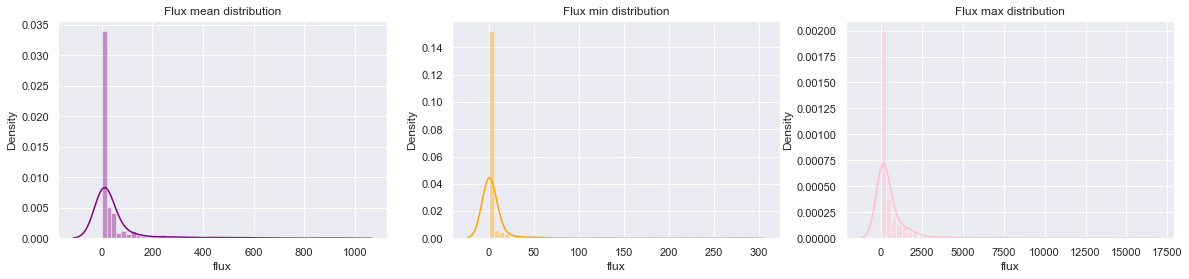

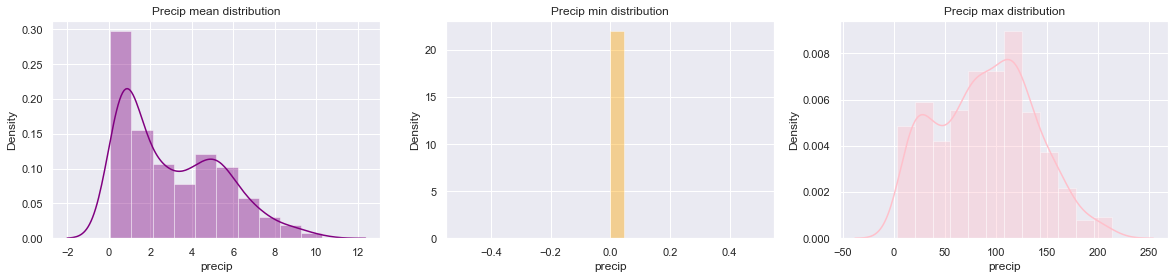

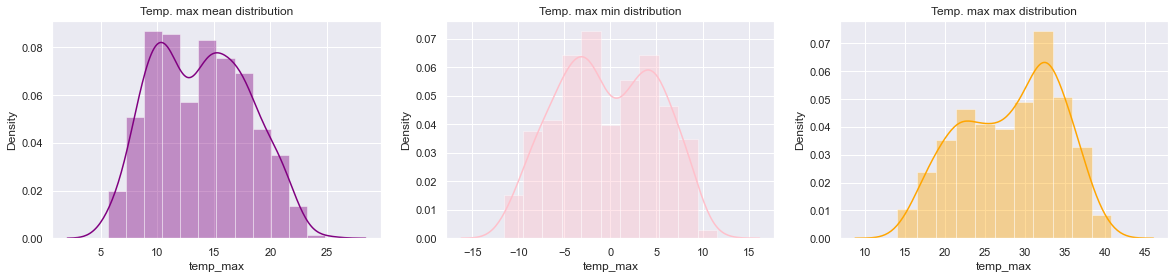

In [13]:
data = flux.groupby(['basin_id']).mean(['flux', 'precip', 'temp_max'])
data_min = flux.groupby(['basin_id']).min(['flux', 'precip', 'temp_max'])
data_max = flux.groupby(['basin_id']).max(['flux', 'precip', 'temp_max'])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
sns.distplot(data['flux'], color = 'purple', ax = ax1)
ax1.set_title('Flux mean distribution')
sns.distplot(data_min['flux'], color = 'orange', ax = ax2)
ax2.set_title('Flux min distribution')
sns.distplot(data_max['flux'], color = 'pink', ax = ax3)
ax3.set_title('Flux max distribution')

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
sns.distplot(data['precip'], color = 'purple', ax = ax1)
ax1.set_title('Precip mean distribution')
sns.distplot(data_min['precip'], color = 'orange', ax = ax2)
ax2.set_title('Precip min distribution')
sns.distplot(data_max['precip'], color = 'pink', ax = ax3)
ax3.set_title('Precip max distribution')
plt.plot()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
sns.distplot(data['temp_max'], color = 'purple', ax = ax1)
ax1.set_title('Temp. max mean distribution')
sns.distplot(data_min['temp_max'], color = 'pink', ax = ax2)
ax2.set_title('Temp. max min distribution')
sns.distplot(data_max['temp_max'], color = 'orange', ax = ax3)
ax3.set_title('Temp. max max distribution')
plt.plot()

#### 2.5.3 Distribution of the values of the observations per zone


1. flux: the south and center part of the country have a higher mean flux than the north.
1. rain: the south path of the country is the rainiest followed by the center and then the north.
1. temp_max: even though one would expect that the north has the highest temperatures, it is not the case. The center and the south show higher maximum temperatures. It is neccesary to check the validity of the data of the northern stations.

Text(0.5, 1.0, 'Temp. max mean distribution per zone')

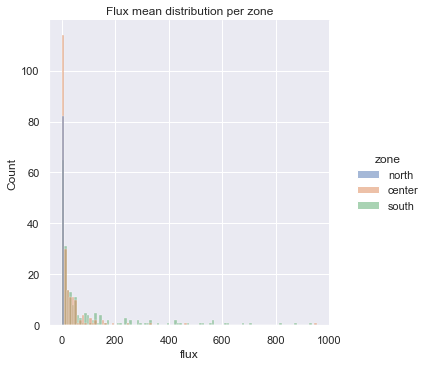

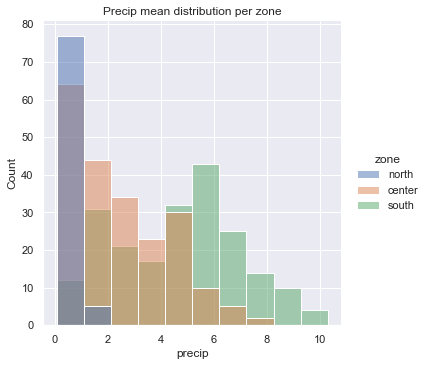

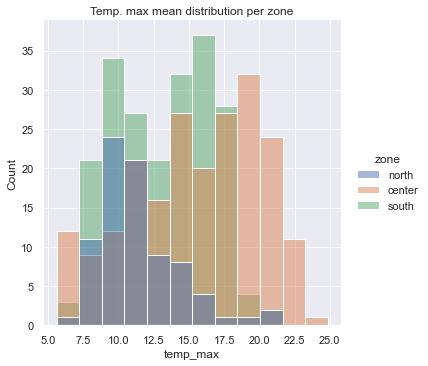

In [14]:
data = flux.groupby(['basin_id','zone']).mean(['flux', 'precip', 'temp_max'])

sns.displot(data = data, x = 'flux', color = 'purple', hue = 'zone')
plt.title('Flux mean distribution per zone')

sns.displot(data = data, x = 'precip', color = 'purple', hue = 'zone')
plt.title('Precip mean distribution per zone')

sns.displot(data = data, x = 'temp_max', color = 'purple', hue = 'zone')
plt.title('Temp. max mean distribution per zone')

Text(0.5, 1.0, 'Temp. max mean distribution per zone')

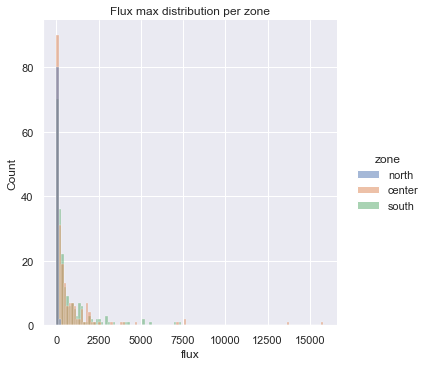

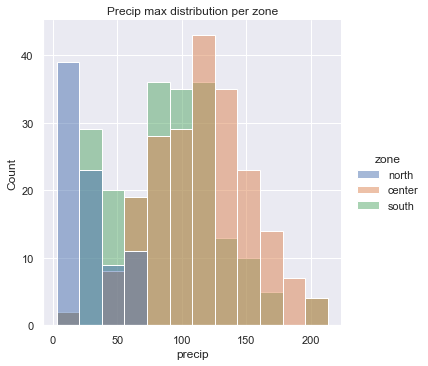

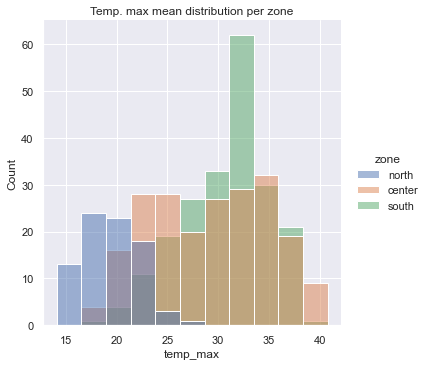

In [15]:
data = flux.groupby(['basin_id','zone']).max(['flux', 'precip', 'temp_max'])

sns.displot(data = data, x = 'flux', color = 'purple', hue = 'zone')
plt.title('Flux max distribution per zone')

sns.displot(data = data, x = 'precip', color = 'purple', hue = 'zone')
plt.title('Precip max distribution per zone')

sns.displot(data = data, x = 'temp_max', color = 'purple', hue = 'zone')
plt.title('Temp. max mean distribution per zone')

The temperature in the zone north is not as expected, because is has the lower values when it should have the maximum values, according to the geography of the country.

<AxesSubplot:xlabel='summer', ylabel='temp_max'>

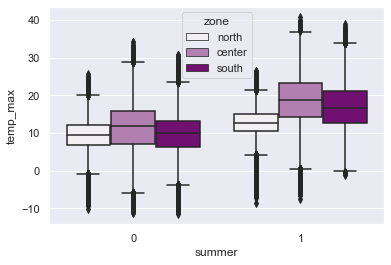

In [16]:
sns.boxplot(data=flux.dropna(), x = 'summer', y = 'temp_max', color = 'purple', hue = 'zone')

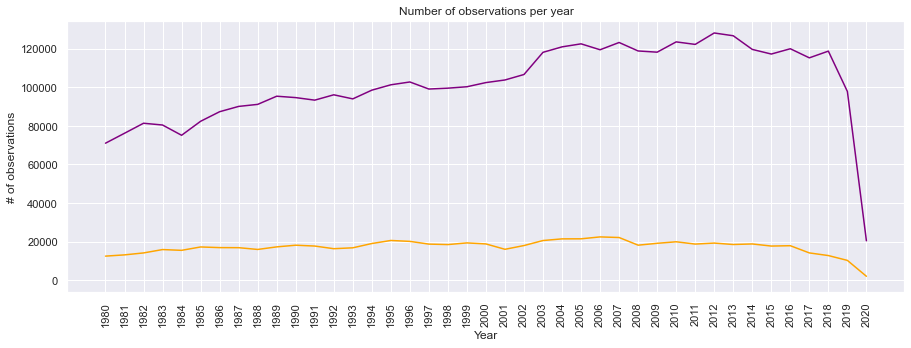

In [17]:
X = np.sort(flux['year'].value_counts().index)
X_axis = np.arange(len(X))

plt.figure(figsize=(15, 5))
plt.plot(X_axis, flux['year'].value_counts().sort_index(), 0.4, color = 'purple', label = 'Zone: north, center and south')
plt.plot(X_axis, flux[flux['zone'] == 'north']['year'].value_counts().sort_index(), 0.4, color = 'orange', label = 'Zone: north')


plt.xticks(X_axis, X, rotation = 90)
plt.xlabel("Year")
plt.ylabel("# of observations")
plt.title("Number of observations per year")
plt.show()

The mean and max precipitations per month for each decade have different values. In particular, the maximum precipitation values are decreasing over time. $\newline$

The mean and max precipitaiones show seasonal behaviour, as winters register higher mean and maximum values.

The year 2020 seems to differ from other yearly tendencies, but there is a very few data to conclude. $\newline$

Text(0.5, 1.0, 'Max precipitation (mm) per month and decade')

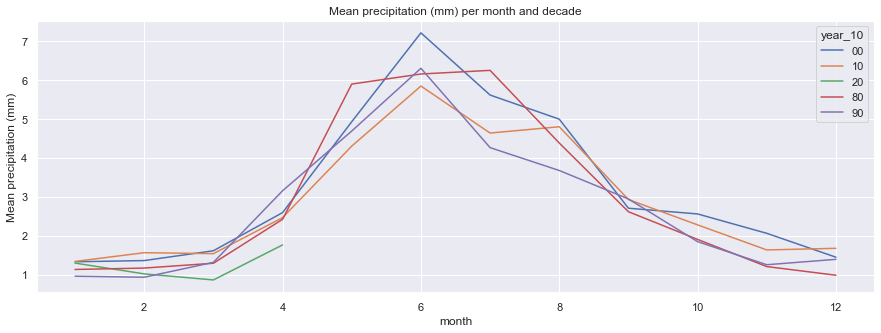

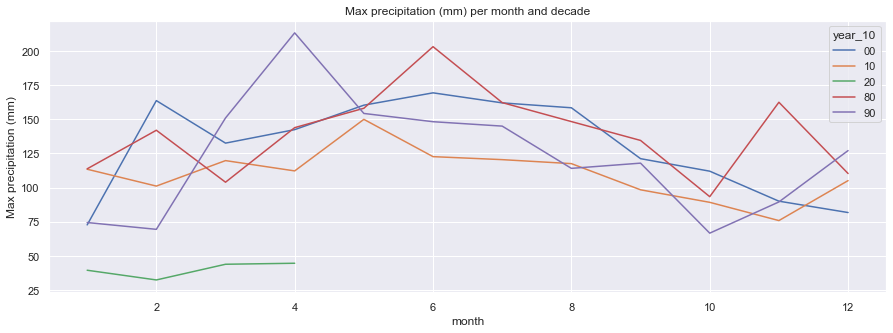

In [18]:
time_interval = 'month'

flux_aggregated_1 = flux.groupby(['year_10', time_interval]).agg(
    precip_min = pd.NamedAgg(column = 'precip', aggfunc= 'min'),
    precip_max = pd.NamedAgg(column = 'precip', aggfunc= 'max'),
    precip_mean = pd.NamedAgg(column = 'precip', aggfunc= 'mean'),
)

flux_aggregated_1.reset_index(inplace = True)

pd.pivot_table(flux_aggregated_1, index = time_interval, columns= 'year_10', values = 'precip_mean').plot(
    figsize = (15, 5), legend = True)
plt.ylabel('Mean precipitation (mm)')
plt.title('Mean precipitation (mm) per month and decade')
pd.pivot_table(flux_aggregated_1, index = time_interval, columns= 'year_10', values = 'precip_max').plot(figsize = (15, 5), legend = True)
plt.ylabel('Max precipitation (mm)')
plt.title('Max precipitation (mm) per month and decade')

In the following graph it is possible to observe the seasonality of the precipitacion (peaks on winter).

[]

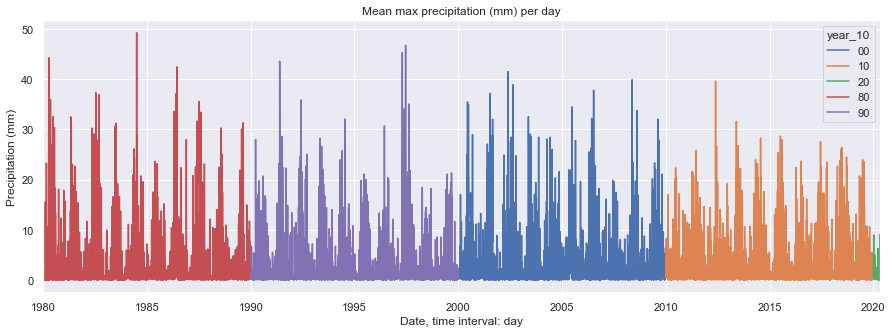

In [19]:
time_interval = 'date'

flux_aggregated_1 = flux.groupby(['year_10', time_interval]).agg(
    precip_min = pd.NamedAgg(column = 'precip', aggfunc= 'min'),
    precip_max = pd.NamedAgg(column = 'precip', aggfunc= 'max'),
    precip_mean = pd.NamedAgg(column = 'precip', aggfunc= 'mean'),
)

flux_aggregated_1.reset_index(inplace = True)
flux_aggregated_1.sort_values(by = 'date', inplace = True)

pd.pivot_table(flux_aggregated_1, index = time_interval, columns= 'year_10', values = 'precip_mean').plot(figsize = (15, 5), legend = True)
plt.xlabel("Date, time interval: day")
plt.ylabel('Precipitation (mm)')
plt.title('Mean max precipitation (mm) per day')
plt.plot()

To observe this tendency, a moving average graph is useful. The graph shows that precipitations have been decreasing since 2018, but in the past these values have decreased and then increased again.

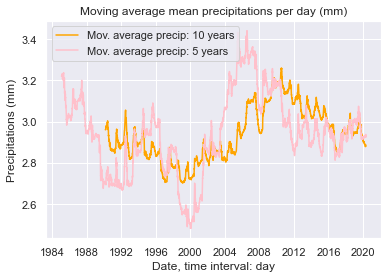

In [20]:
flux_aggregated_1["Moving average 5 years precip. max"] = flux_aggregated_1['precip_mean'].rolling(7*53*5).mean()
flux_aggregated_1["Moving average 10 years precip. max"] = flux_aggregated_1['precip_mean'].rolling(7*53*10).mean()

X = flux_aggregated_1['date']
sns.lineplot(X , flux_aggregated_1['Moving average 10 years precip. max'], color = 'orange', label = 'Mov. average precip: 10 years')
sns.lineplot(X , flux_aggregated_1['Moving average 5 years precip. max'], color = 'pink', label = 'Mov. average precip: 5 years')


# plt.xticks(X_axis, X, rotation = 90)
plt.xlabel("Date, time interval: day")
plt.ylabel("Precipitations (mm)")
plt.title("Moving average mean precipitations per day (mm)")
plt.show()

The mean, minimum and maximum maximum temperature per decade also show a seasonal behaviour for this variable. Winter season contains the lowest values, which makes sense. $\newline$.

The year 2020 has abnormal behaviour, but there are very few observations to conclude.

Text(0.5, 1.0, 'Mean temp. max (ºC) per month and decade')

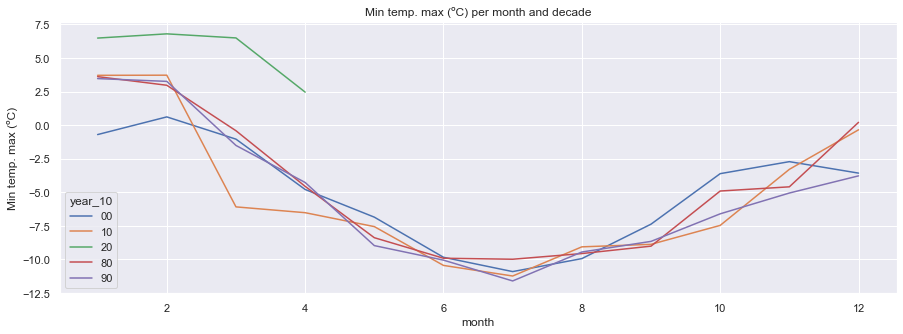

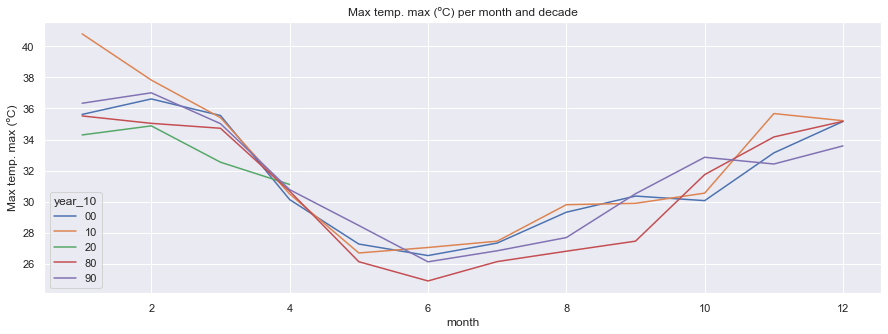

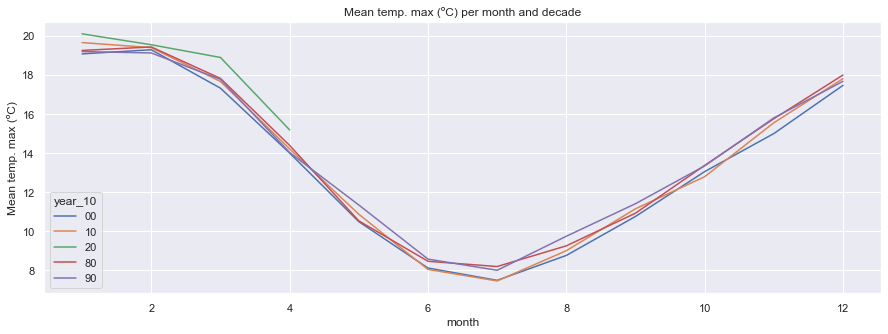

In [21]:
time_interval = 'month'

flux_aggregated_2 = flux.groupby(['year_10', time_interval]).agg(
    temp_min = pd.NamedAgg(column = 'temp_max', aggfunc= 'min'),
    temp_max = pd.NamedAgg(column = 'temp_max', aggfunc= 'max'),
    temp_mean = pd.NamedAgg(column = 'temp_max', aggfunc= 'mean'),
)

flux_aggregated_2.reset_index(inplace = True)

pd.pivot_table(flux_aggregated_2, index = time_interval, columns= 'year_10', values = 'temp_min').plot(figsize = (15, 5), legend = True)
plt.ylabel('Min temp. max (ºC)')
plt.title('Min temp. max (ºC) per month and decade')
pd.pivot_table(flux_aggregated_2, index = time_interval, columns= 'year_10', values = 'temp_max').plot(figsize = (15, 5), legend = True)
plt.ylabel('Max temp. max (ºC)')
plt.title('Max temp. max (ºC) per month and decade')
pd.pivot_table(flux_aggregated_2, index = time_interval, columns= 'year_10', values = 'temp_mean').plot(figsize = (15, 5), legend = True)
plt.ylabel('Mean temp. max (ºC)')
plt.title('Mean temp. max (ºC) per month and decade')

The seasonality becomes clearer in the following graph:

Text(0.5, 1.0, 'Mean max temp. max (ºC) per day')

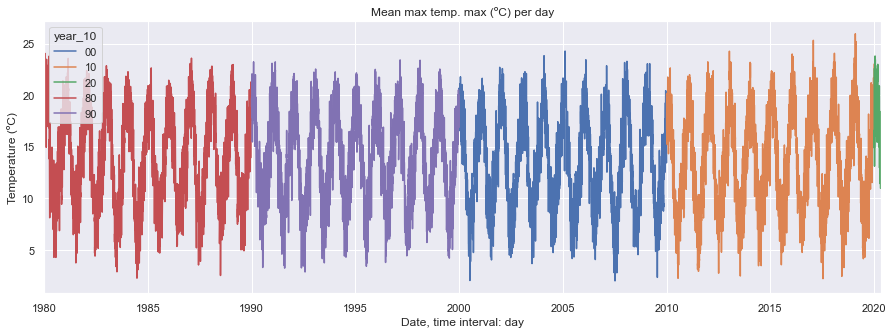

In [22]:
time_interval = 'date'

flux_aggregated_2 = flux.groupby(['year_10', time_interval]).agg(
    temp_min = pd.NamedAgg(column = 'temp_max', aggfunc= 'min'),
    temp_max = pd.NamedAgg(column = 'temp_max', aggfunc= 'max'),
    temp_mean = pd.NamedAgg(column = 'temp_max', aggfunc= 'mean'),
)

flux_aggregated_2.reset_index(inplace = True)
flux_aggregated_2.sort_values(by = 'date', inplace = True)

pd.pivot_table(flux_aggregated_2, index = time_interval, columns= 'year_10', values = 'temp_mean').plot(figsize = (15, 5), legend = True)
plt.xlabel("Date, time interval: day")
plt.ylabel('Temperature (ºC)')
plt.title('Mean max temp. max (ºC) per day')

The mean maximum temperature per date is increasing since 2012, which is in the next graph:

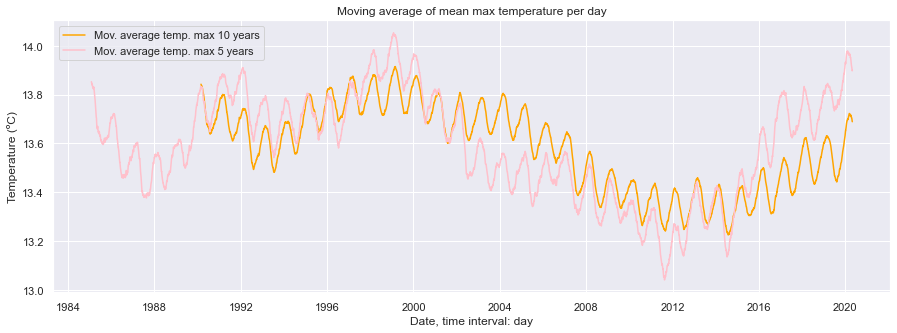

In [23]:
flux_aggregated_2["Moving average 5 years temp. max"] = flux_aggregated_2['temp_mean'].rolling(7*53*5).mean()
flux_aggregated_2["Moving average 10 years temp. max"] = flux_aggregated_2['temp_mean'].rolling(7*53*10).mean()

plt.figure(figsize=(15, 5))

X = flux_aggregated_2['date']
X_axis = np.arange(len(X))

sns.lineplot(X, flux_aggregated_2['Moving average 10 years temp. max'], color = 'orange', label = 'Mov. average temp. max 10 years')
sns.lineplot(X, flux_aggregated_2['Moving average 5 years temp. max'], color = 'pink', label = 'Mov. average temp. max 5 years')


# plt.xticks(X_axis, X, rotation = 90)
plt.xlabel("Date, time interval: day")
plt.ylabel("Temperature (ºC)")
plt.title("Moving average of mean max temperature per day")
plt.show()

### 2.5 Missing dates

There are no missing values in the actual data, but there is plenty of missing date entries in the data. Hence, it is neccesarry to fill the database with those dates.

In [24]:
flux.date.max()

Timestamp('2020-04-30 00:00:00')

The percentage of available data per station is calculated as the ratio between the number of days with available data within a time series and the difference in days between the minimum and maximum date of the same series. A histogram showing these percentages for each station is shown below.
It is observable that approximately 75% of the stations have almost 80% of available data. Also, there are stations with very few observations.

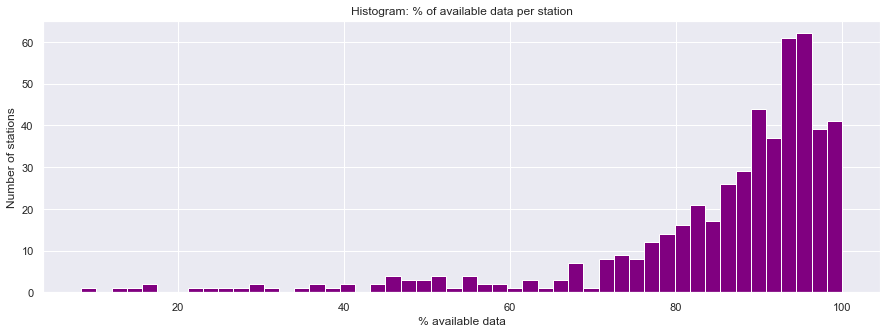

In [25]:
missing_days = []
missing_days_2 = []
max_date = flux.date.max()
for id in flux['basin_id'].unique():
    df_cod = flux[flux['basin_id'] == id]
    idx = pd.date_range(df_cod.date.min(), df_cod.date.max())
    missing_days.append(np.round(len(df_cod) / len(idx) * 100,2))
    missing_days_2.append(
        [df_cod['basin_id'].unique()[0], df_cod['lat'].unique()[0], df_cod['lon'].unique()[0], np.round(len(df_cod) / len(idx) * 100,2)]
        )

plt.figure(figsize=(15, 5))
plt.hist(missing_days, bins = 50, color = 'purple')
plt.xlabel("% available data")
plt.ylabel('Number of stations')
plt.title('Histogram: % of available data per station')
plt.show()

Considering that the time windows for each time seris is the minimun date -> maximum date of all series, a histogram of the available data por station is showns. Is observable that almost 60% of the stations have almost 80% of the available data. Also, some stations have very few data. 
$\newline$

Comparing this histogram with the last one, is possible to conclude that most stations have recent data and a few stations don't have recent data.

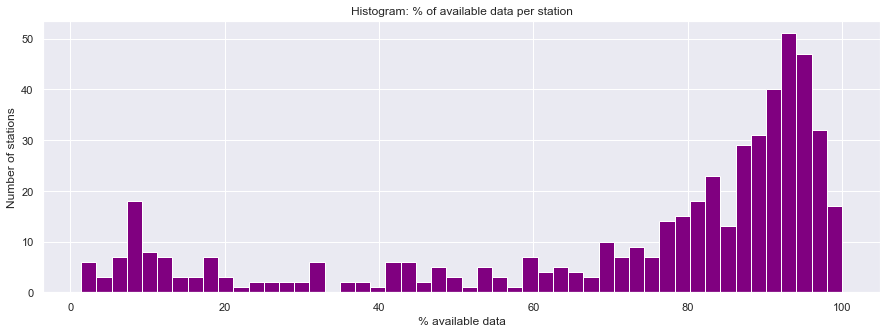

In [26]:
missing_days = []
missing_days_2 = []
max_date = flux.date.max()
for id in flux['basin_id'].unique():
    df_cod = flux[flux['basin_id'] == id]
    idx = pd.date_range(df_cod.date.min(), max_date)
    missing_days.append(np.round(len(df_cod) / len(idx) * 100,2))
    missing_days_2.append(
        [df_cod['basin_id'].unique()[0], df_cod['lat'].unique()[0], df_cod['lon'].unique()[0], np.round(len(df_cod) / len(idx) * 100,2)]
        )


plt.figure(figsize=(15, 5))
plt.hist(missing_days, bins = 50, color = 'purple')
plt.xlabel("% available data")
plt.ylabel('Number of stations')
plt.title('Histogram: % of available data per station')
plt.show()

In the following code, a database where the missing days per station are filled is shown.

In [27]:
flux.sort_values(by = 'basin_id', inplace= True)
df_flux = []

for id in flux['basin_id'].unique():
    df_code = flux[flux['basin_id'] == id].sort_values(by = 'date')
    idx = pd.date_range(min(df_code['date']), max(df_code['date']))
    df_code.set_index('date', inplace= True, drop = True)
    df_code.index = pd.DatetimeIndex(df_code.index)
    df_code = df_code.reindex(idx).reset_index(drop = False)
    df_code.rename(columns= {'index': 'date'}, inplace = True)
    df_code['basin_id'] = id
    for col in df_cod.columns:
        if col not in ['flux', 'precip', 'temp_max']:
            df_code[col] = df_code[col].fillna(method = 'ffill')
    df_flux.append(df_code)
    
flux_full = pd.concat(df_flux)
flux_full.reset_index(drop = True, inplace = True)
flux_full.head(2)

date  basin_id   flux  precip   temp_max                 gauge_name  \
0 1980-01-01   1001001  0.579     0.0  10.685653  Rio Caquena En Nacimiento   
1 1980-01-02   1001001  0.543     0.0  11.470960  Rio Caquena En Nacimiento   

       lat      lon    mean_elev   area_km2  ...  month  week_number  \
0 -18.0769 -69.1961  4842.449328  49.711859  ...    1.0          1.0   
1 -18.0769 -69.1961  4842.449328  49.711859  ...    1.0          1.0   

   day_number  year_10  summer south  center  north   zone  river_id  
0         1.0       80     1.0   0.0     0.0    3.0  north    1001.0  
1         2.0       80     1.0   0.0     0.0    3.0  north    1001.0  

[2 rows x 22 columns]

In [28]:
missing_days_2 = pd.DataFrame(missing_days_2)
missing_days_2.rename(columns = {0: 'basin_id', 1: 'lat', 2: 'lon', 3:'availabe'}, inplace = True)
missing_days_2.head(2)

basin_id      lat      lon  availabe
0   1001001 -18.0769 -69.1961     41.58
1   1001002 -17.9942 -69.2550     83.55

The total data is measured as the number of days between the first observation of a given station to the day 2020-04-30. $\newline$
Green: stations with more than 80% of the data available. $\newline$
Purple: sations with more tan 60% and less than 80% of the data available. $\newline$
Red: stations with less than 60% of the data available. $\newline$

It is observable that in the north of the country there are less stations (less watersheds) and also less data per station compared to the rest of the country.
Extreme flux can be predicted using precipitation and maximum temperature per day. However, there are stations where this information is missing, which does not allow the analysis to be done. Nevertheless, data shows that for almost every station where this happens there is a close station that does contain that value.

In [29]:
m = folium.Map()
    
for i in missing_days_2.iterrows():
    if i[1][3] >= 80:
        color = 'green'
    elif i[1][3] >= 60 and i[1][3] < 80:
        color = 'purple'
    elif i[1][3] < 60:
        color = 'red'
    
    
    folium.Marker(
        location=[i[1][1], i[1][2]], 
        popup = (
            'base_id: {f1}'.format(f1 = i[1][0]),
            'available data: {f1}%'.format(f1 = i[1][3])),
        icon = folium.Icon(color = color)

    ).add_to(m)
    
    
sw = missing_days_2[['lat', 'lon']].min().values.tolist()
ne = missing_days_2[['lat', 'lon']].max().values.tolist()
m.fit_bounds([sw, ne]) 
m

### 2.6 Geographic clustering

Considering that the maximum temperature and precipitation values are required for the analysis, and that these values are expected to be similar for stations that are close to each other, missing values could be filled with information from nearby stations.

In [30]:
flux_cluster = flux.groupby(['basin_id', 'lat', 'lon']).sum().reset_index()[['basin_id', 'lat', 'lon']]

kmeans = KMeans(n_clusters= 120, random_state= 0)
cluster = kmeans.fit(flux_cluster[['lat', 'lon']])
flux_cluster['labels'] = kmeans.labels_

color = [f'{"#%06x" % random.randint(0, 0xFFFFFF)}' for i in range(len(kmeans.labels_))]

m = folium.Map()
    
for i in flux_cluster.iterrows():
    
    
    folium.Marker(
        location=[i[1][1], i[1][2]], 
        popup = (i[1][0]),
        icon = folium.Icon(color = 'white',
                           icon_color = color[int(i[1][3])]
    )

    ).add_to(m)    
    
sw = flux_cluster[['lat', 'lon']].min().values.tolist()
ne = flux_cluster[['lat', 'lon']].max().values.tolist()
m.fit_bounds([sw, ne]) 
m

In [31]:
flux_full  = pd.merge(flux_full, flux_cluster[['basin_id', 'labels']], how = 'left', on = 'basin_id')

In [32]:
df_flux = []
for cluster in flux_full['labels'].unique():
    df_label = flux_full[flux_full['labels'] == cluster]
    df_label.sort_values(by = 'date', inplace = True)
    df_label['temp_max'].interpolate(inplace = True)
    df_label['precip'].interpolate(limit = 5, inplace = True)
    df_flux.append(df_label)
    
flux_full = pd.concat(df_flux)
flux_full.reset_index(drop = True, inplace = True)
flux_full.head(2)

date  basin_id   flux  precip   temp_max                 gauge_name  \
0 1980-01-01   1001001  0.579     0.0  10.685653  Rio Caquena En Nacimiento   
1 1980-01-01   1001002  1.620     0.0  11.287282   Rio Caquena En Vertedero   

       lat      lon    mean_elev    area_km2  ...  week_number  day_number  \
0 -18.0769 -69.1961  4842.449328   49.711859  ...          1.0         1.0   
1 -17.9942 -69.2550  4652.603986  467.556222  ...          1.0         1.0   

   year_10  summer  south center  north   zone  river_id  labels  
0       80     1.0    0.0    0.0    3.0  north    1001.0      78  
1       80     1.0    0.0    0.0    3.0  north    1001.0      78  

[2 rows x 23 columns]

## 3. Plot flux, temperature and precipitations

In [33]:
def plot_one_timeserie(cod_station, variable, min_date, max_date):
    if cod_station in flux_full['basin_id'].unique():
        df_cod = flux_full[
            (flux_full['basin_id'] == cod_station) &
            (flux_full['date'] >= pd.to_datetime(min_date)) &
            (flux_full['date'] <= pd.to_datetime(max_date) )
            ].sort_values(by = 'date')

        plt.figure(figsize=(15, 7))
        sns.lineplot(x='date', y=variable, data=df_cod, linewidth=0.5)
        plt.xlabel('Date, time interval: daily')
        plt.ylabel('{f0}'.format(f0 = str(variable)))
        plt.title('{f0} per day between {f1} and {f2}, station: {f3}'.format(
            f0 = str(variable),
            f1 = str(min_date),
            f2 = str(max_date),
            f3 = str(cod_station)))
        plt.show()
    else:
        print('{fcode} is not a code station'.format(fcode = cod_station))

The graph shows the seasonality of the variables precipitations and temp_max.

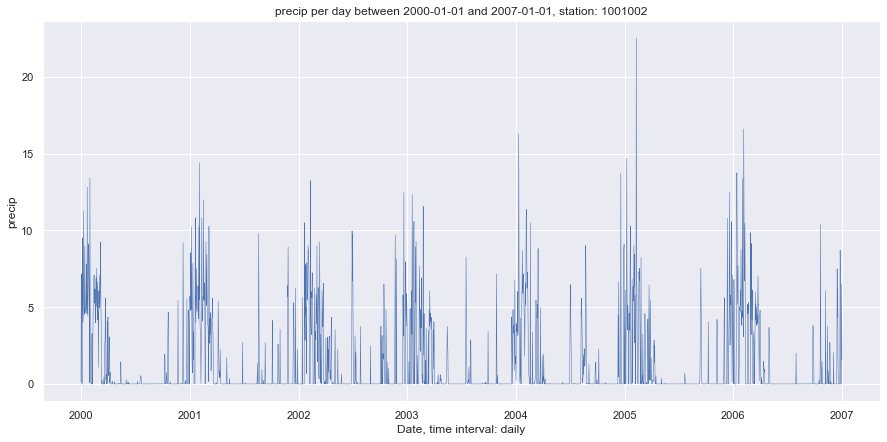

In [34]:
plot_one_timeserie(1001002, 'precip','2000-01-01', '2007-01-01')

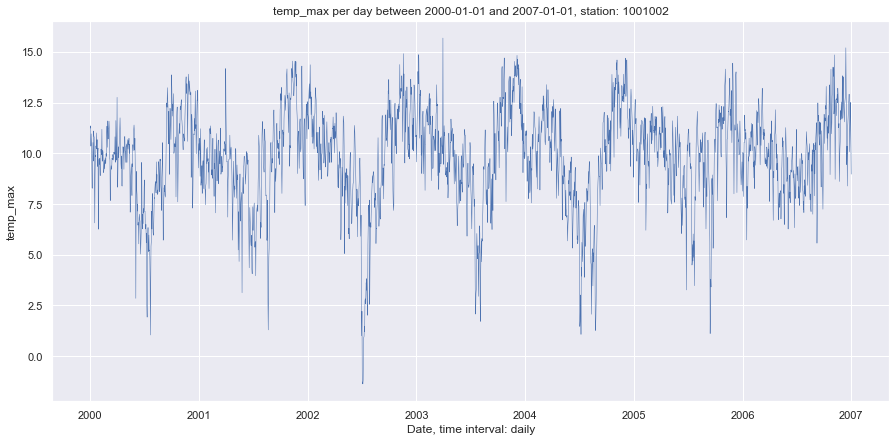

In [35]:
plot_one_timeserie(1001002, 'temp_max','2000-01-01', '2007-01-01')

Before each flux peak, there is usually a peak of temp_max and precip.

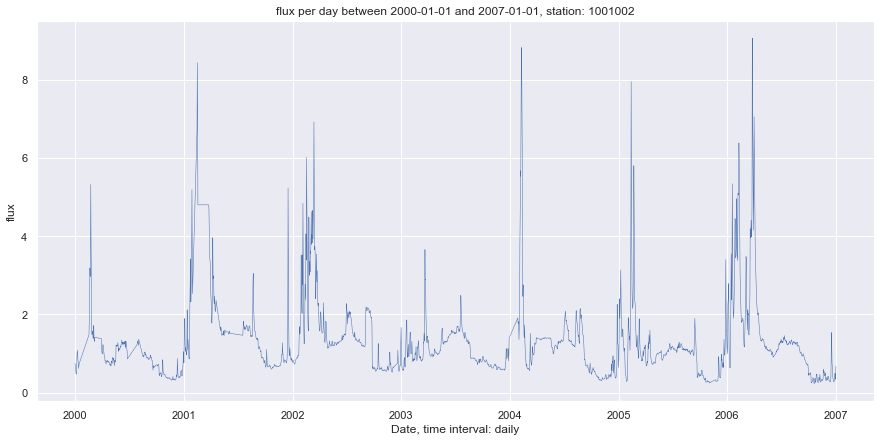

In [36]:
plot_one_timeserie(1001002, 'flux','2000-01-01', '2007-01-01')

In [37]:
def plot_three_timeseries(cod_station, min_date, max_date):
    if cod_station in flux_full['basin_id'].unique():
        
        
        df_cod = flux_full[
            (flux_full['basin_id'] == cod_station)
        ].sort_values(by = 'date')
        
        df_cod['flux'] =  (df_cod['flux']-df_cod['flux'].mean())/df_cod['flux'].std()
        df_cod['precip'] =  (df_cod['precip']-df_cod['precip'].mean())/df_cod['precip'].std()
        df_cod['temp_max'] =  (df_cod['temp_max']-df_cod['flux'].mean())/df_cod['temp_max'].std()   
        
        df_cod = df_cod[
            (df_cod['date'] >= pd.to_datetime(min_date)) &
            (df_cod['date'] <= pd.to_datetime(max_date) )
        ]
        
        plt.figure(figsize=(20, 7))
        
        sns.lineplot(x='date', y='precip', data=df_cod, linewidth=1, label='precip')
        sns.lineplot(x='date', y='temp_max', data=df_cod, linewidth=1, label='temp_max')
        sns.lineplot(x='date', y='flux', data=df_cod, linewidth=1, label='flux')
        
        plt.xlabel('Date, time interval: daily')
        plt.ylabel('Normalize scale')
        plt.title('Variables per day between {f1} and {f2}, station: {f3}'.format(
            f1 = str(min_date),
            f2 = str(max_date),
            f3 = str(cod_station)))
        plt.show()
    else:
        print('{fcode} is not a code station'.format(fcode = cod_station))

The graph shows that the flux variable have a very similar shape of the temp_max variable, but when there is not rain, then the flux variable have a different behaviour when comparing with temp_max. In that case flux have lower values.


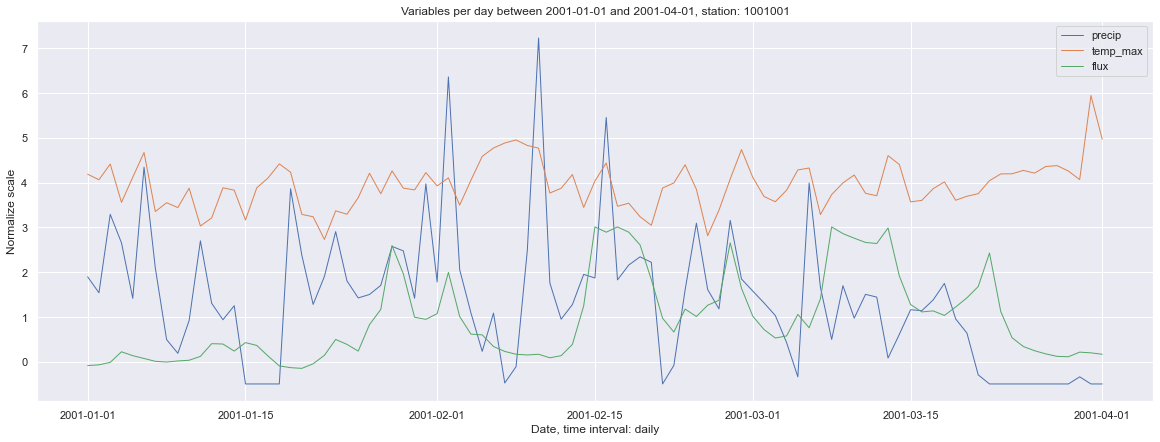

In [38]:
plot_three_timeseries(1001001, '2001-01-01', '2001-04-01')

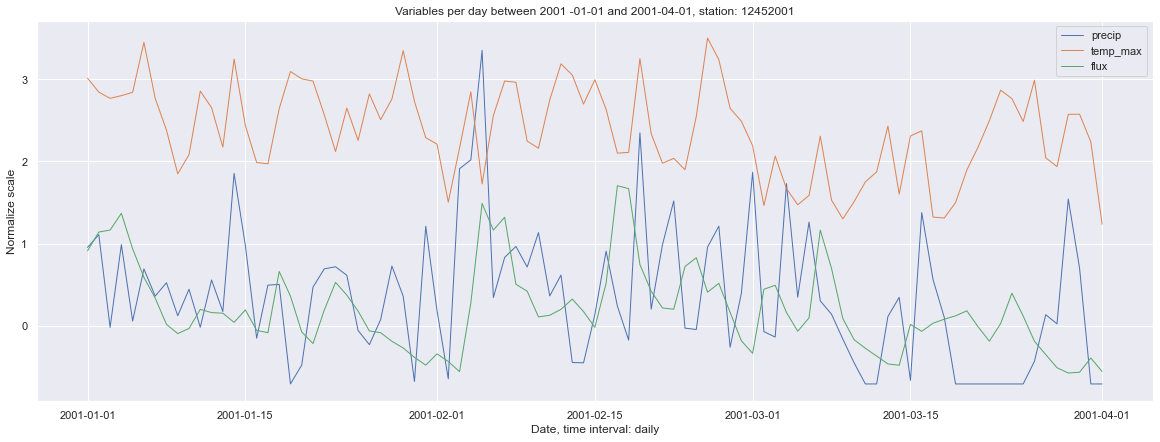

In [39]:
plot_three_timeseries(12452001, '2001 -01-01', '2001-04-01')

## 4. Create three variables
flux_extreme $\newline$
temp_extreme $\newline$
precip_extreme $\newline$
This variables should take the value of 1 when that variable in a specific day was extreme. Being extreme could be considered as being greater than expected. For example, a flux can be considered as extreme (value 1) when is over the 95 percentile of the flux distribution for that specific season, and takes the value 0 otherwise. Taking into account the seasonality of that variables is very important, because  could be considered as extreme in wintertime, but it’d be a normal temperature for summertime. $\newline$

1. Do you consider this a good way of capturing extreme events? Or you would have used a different method? Which one?

Answer: $\newline$

Given the seasonality of the data, is important to divide the extreme temperatures by season. I prefer to use more robust methods to detect anomalies such as isolation forest. It is because when using quantile 95, for construction, there will be a 5% of the data that will be considered as extreme values, but that could not be the case. Therefore observations that are not extreme will be considered as extreme and will confused the data anlysis. It is possible that just the 2% of the data is extreme for one variable and maybe 8% for other variable. 
$\newline$

Also, the max temperature and precipitations are charasteristics that are continuesly changuing, so it is possible that nowadays normal temperatures could have been extreme temperatures in the past, so I consider that is importante to calculate the extreme values within a time range.



In the next cells the extreme variables are created for the flux and flux_full (flux with al the missing dates) dataframes. The granularity of the data is daily per station and season. I choose this approuch because as seen in the EDA, different watershed have very different flux, preicipation and temp max. Therefore if all watershed are using together, the watersheds with larger values will confuse the metrix, because just them will be assigned with extreme values, even when some watershed will be having extreme fluxs but are small compare to other bigger rivers.

In [40]:
df_flux = []
for cod_station in flux['basin_id'].unique():
    for summer in flux['summer'].unique():
        df_cod = flux[(flux['basin_id'] == cod_station) & (flux['summer'] == summer)]
        treshold_flux = df_cod['flux'].quantile(0.95)
        treshold_precip = df_cod['precip'].quantile(0.95)
        treshold_temp_max = df_cod['temp_max'].quantile(0.95)
        df_cod['flux_extreme'] = (df_cod['flux'] > treshold_flux).astype(int)
        df_cod['temp_extreme'] = (df_cod['flux'] > treshold_temp_max).astype(int)
        df_cod['precip_extreme'] = (df_cod['flux'] > treshold_precip).astype(int)
        df_flux.append(df_cod)
    
flux = pd.concat(df_flux)
flux.reset_index(drop = True, inplace = True)

In [41]:
df_flux = []
for cod_station in flux_full['basin_id'].unique():
    for summer in flux_full['summer'].unique():
        df_cod = flux_full[(flux_full['basin_id'] == cod_station) & (flux_full['summer'] == summer)]
        treshold_flux = df_cod['flux'].quantile(0.95)
        treshold_precip = df_cod['precip'].quantile(0.95)
        treshold_temp_max = df_cod['temp_max'].quantile(0.95)
        df_cod['flux_extreme'] = (df_cod['flux'] > treshold_flux).astype(int)
        df_cod['temp_extreme'] = (df_cod['flux'] > treshold_temp_max).astype(int)
        df_cod['precip_extreme'] = (df_cod['flux'] > treshold_precip).astype(int)
        df_flux.append(df_cod)
    
flux_full = pd.concat(df_flux)
flux_full.reset_index(drop = True, inplace = True)

Also, using flux_full, is posible to check when heat waves happend. A heatwave is when two days or more have a temp_extreme value (=1).

In [42]:
df_flux = []
sum = 0
for cod_station in flux_full['basin_id'].unique():
    for summer in flux_full['summer'].unique():
        temp_extrem = []
        df_cod = flux_full[(flux_full['basin_id'] == cod_station) & (flux_full['summer'] == summer)]
        df_cod.sort_values(by = ['date'], inplace = True)
        df_cod.reset_index(inplace = True)
        for i in range(len(df_cod)):
            if df_cod.loc[i, 'temp_extreme'] == 1:
                sum = sum + 1
                if sum >= 2:
                    sum = 0
                    temp_extrem.append(1)
                else:
                    temp_extrem.append(0)
            else:
                sum = 0
                temp_extrem.append(0)
        df_cod['heat_wave'] = temp_extrem
        df_flux.append(df_cod)
flux_full = pd.concat(df_flux)
flux_full.reset_index(drop = True, inplace= True)

## 5. Plot the variable flux_extreme. 
1. Are there any different behaviours among different watersheds?

Answer: $\newline$ 
From the graph it is possible to conclude that the different zones of the country have different seasonality for flux extreme.

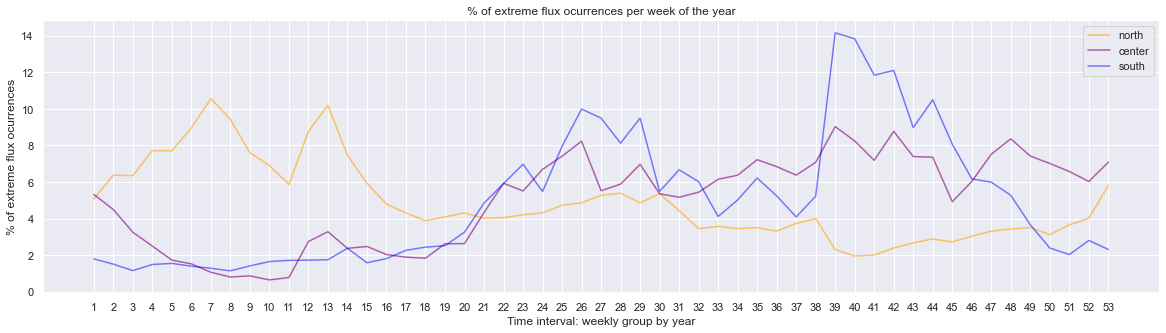

In [43]:
time_interval = 'week_number'

flux_zone = flux.groupby(['zone', time_interval]).sum(['flux_extreme', 'temp_extreme', 'precip_extreme', 'unique'])[['flux_extreme', 'temp_extreme', 'precip_extreme', 'unique']]
flux_zone['flux_extreme_2'] = flux_zone['flux_extreme'] / flux_zone['unique'] * 100
flux_zone['temp_extreme_2'] = flux_zone['temp_extreme'] / flux_zone['unique'] * 100
flux_zone['precip_extreme_2'] = flux_zone['precip_extreme'] / flux_zone['unique'] * 100
flux_zone.reset_index(inplace = True)

X = flux_zone[flux_zone['zone'] == 'south'][time_interval]
X_axis = np.arange(len(X))
plt.figure(figsize=(20, 5))

sns.lineplot(X_axis , flux_zone[flux_zone['zone'] == 'north']['flux_extreme_2'], color = 'orange', alpha = 0.6, label = 'north')
sns.lineplot(X_axis , flux_zone[flux_zone['zone'] == 'center']['flux_extreme_2'], color = 'purple', alpha = 0.6, label = 'center')
sns.lineplot(X_axis , flux_zone[flux_zone['zone'] == 'south']['flux_extreme_2'], color = 'blue',  alpha= 0.5, label = 'south')

plt.xticks(X_axis, X)
plt.xlabel("Time interval: weekly group by year")
plt.ylabel("% of extreme flux ocurrences")
plt.title("% of extreme flux ocurrences per week of the year")
plt.show()

To check if there is diffent behaiviours of flux extreme per watersheds, it is useful to cluster the time series of flux extreme per station. For this porpouse, the data is group by station and month. For that unit the % of flux extreme is calculated. Then, the distance beetwen the time series (one for each station) is calculated using correlation metrix.

In [44]:
time_interval = 'month'

flux_zone_2 = flux.groupby(['basin_id', time_interval]).sum(['flux_extreme', 'temp_extreme', 'precip_extreme', 'unique'])[['flux_extreme', 'temp_extreme', 'precip_extreme', 'unique']]
flux_zone_2['flux_extreme_2'] = flux_zone_2['flux_extreme'] / flux_zone_2['unique'] 
flux_zone_2['temp_extreme_2'] = flux_zone_2['temp_extreme'] / flux_zone_2['unique'] 
flux_zone_2['precip_extreme_2'] = flux_zone_2['precip_extreme'] / flux_zone_2['unique'] 
flux_zone_2.reset_index(inplace = True)
flux_zone_2_pt = flux_zone_2.pivot_table(index = time_interval, values ='flux_extreme_2', columns = 'basin_id')
flux_zone_2_pt_corr = flux_zone_2_pt.corr()
flux_zone_2_pt_corr.interpolate(inplace = True)

Using a hierarchical clustering approuch is possible to observate that there are 3 main groups of series.

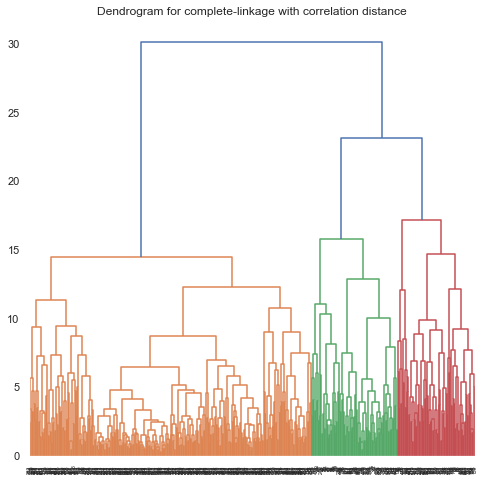

In [45]:
def hierarchical_clustering(dist_mat, method='complete'):
    if method == 'complete':
        Z = complete(dist_mat)
    if method == 'single':
        Z = single(dist_mat)
    if method == 'average':
        Z = average(dist_mat)
    if method == 'ward':
        Z = ward(dist_mat)
    
    fig = plt.figure(figsize=(8, 8))
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()
    
    return Z

linkage_matrix = hierarchical_clustering(flux_zone_2_pt_corr)

In [46]:
flux_zone_2_pt.interpolate(inplace = True)

time_a = []
for i in flux_zone_2_pt.columns:
    time_a.append(flux_zone_2_pt[i])
    
X = to_time_series_dataset(time_a)

gak_km = KernelKMeans(n_clusters=3, kernel="gak")
labels_gak = gak_km.fit_predict(X)
a = pd.DataFrame(flux_zone_2_pt.columns, labels_gak).reset_index()
b = flux.groupby(['basin_id']).min(['lat', 'lon'])[['lat', 'lon']]
c = pd.merge(a, b, on = 'basin_id')
c['index'].value_counts()

1    300
2    124
0     79
Name: index, dtype: int64

In [47]:
flux_full.drop(columns = 'index', inplace = True)
flux_full = pd.merge(flux_full, a, how = 'left', on = 'basin_id')
flux_full.drop(columns = 'labels', inplace = True)
flux_full.rename(columns= {'index': 'labels'}, inplace = True)

The following graph shows that the clusters have the different distribution of % flux extreme per month. $\newline$
1. cluster 0: has a peak of events on month 10.
2. cluster 1: has a peak of events on month 12.
3. cluster 2: has a peak of events on month 2 and 3.

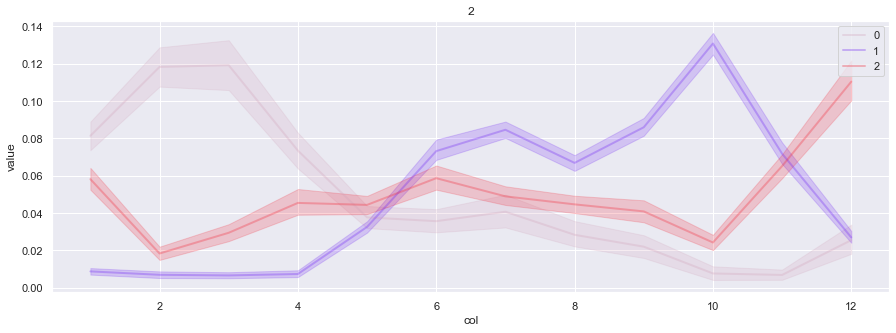

In [48]:
c1 = pd.merge(flux_zone_2_pt.T, a, on = 'basin_id')
c1.rename(columns= {'index' : 'Group'}, inplace = True)
color = [f'{"#%06x" % random.randint(0, 0xFFFFFF)}' for i in range(len(labels_gak))]

plt.figure(figsize=(15, 5))
for i in np.sort(c1['Group'].unique()):
    df_cod = c1[c1['Group'] == i]
    df_cod.drop(columns= ['Group'], inplace = True)

    df_cod_2 = df_cod.melt(id_vars=['basin_id'], var_name='col')

    
    sns.lineplot(x='col', 
                y='value',
                data=df_cod_2,
                color = color[i], label = str(i), alpha = 0.3, linewidth = 2)
    
    plt.title(str(i))

Looking how those cluster are represented in a map, is possible to understand that the 3 main behaviours correspond to extreme north, extreme south and middle of the country. As mentioned before, Chile has different weather characteristic along the country, so it make perfect sense to have different behaviours in the clusters that are formed.

In [49]:
m = folium.Map()
    
for i in c.iterrows():
    
    folium.Marker(
        location=[i[1][2], i[1][3]], 
        popup = ('basin_id: {f1}, cluster {f2}'.format(f1 = i[1][1], f2 = i[1][0])
            ),
        icon = folium.Icon(color = 'white',
                           icon_color = color[int(i[1][0])]
            )

    ).add_to(m)    
    
sw = flux_cluster[['lat', 'lon']].min().values.tolist()
ne = flux_cluster[['lat', 'lon']].max().values.tolist()
m.fit_bounds([sw, ne]) 
m

In conclusion, there are different behaviours among different watersheds. The main differences are between stations in the extreme north, extreme south and rest of the country.

## 6. Plot the percentage of extreme events during time. Have they become more frequent?

In [50]:
time_interval = 'date'

flux_aggregated_3 = flux.groupby([time_interval]).agg(
    precip_max = pd.NamedAgg(column = 'precip_extreme', aggfunc= 'sum'),
    temp_max = pd.NamedAgg(column = 'temp_extreme', aggfunc= 'sum'),
    flux_max = pd.NamedAgg(column = 'flux_extreme', aggfunc= 'sum'),
    unique = pd.NamedAgg(column = 'unique', aggfunc= 'sum')
)

flux_aggregated_3['precip_max_per'] = np.round(
    flux_aggregated_3['precip_max'] / flux_aggregated_3['unique'] * 100, 2
)

flux_aggregated_3['temp_max_per'] = np.round(
    flux_aggregated_3['temp_max'] / flux_aggregated_3['unique'] * 100, 2
)

flux_aggregated_3['flux_max_per'] = np.round(
    flux_aggregated_3['flux_max'] / flux_aggregated_3['unique'] * 100, 2
)

flux_aggregated_3.reset_index(inplace = True)
flux_aggregated_3.sort_values(by = 'date', inplace = True)

flux_aggregated_3["Moving average 10 years precip. extreme percentage"] = flux_aggregated_3['precip_max_per'].rolling(7*53*10).mean()
flux_aggregated_3["Moving average 10 years temp. extreme percentage"] = flux_aggregated_3['temp_max_per'].rolling(7*53*10).mean()
flux_aggregated_3["Moving average 10 years flux extreme percentage"] = flux_aggregated_3['flux_max_per'].rolling(7*53*10).mean()

To study the tendency of the time series, the mean averages are calculated as an indicator.
$\newline$
From the following graph is possible to conclude that the frequency of precip extreme have been decresingly in since 2010.

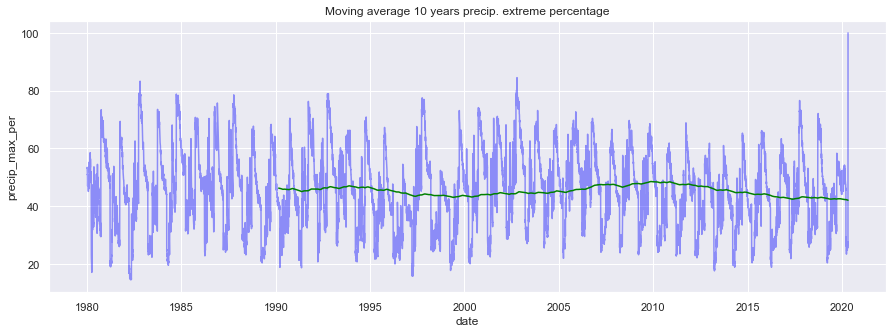

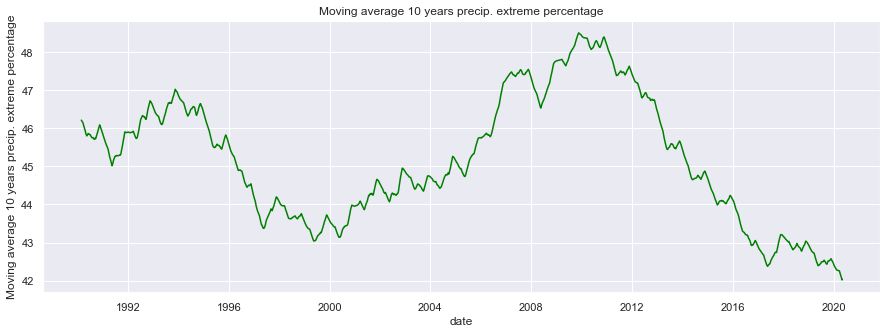

In [51]:
plt.figure(figsize=(15, 5))
sns.lineplot(flux_aggregated_3['date'], flux_aggregated_3['precip_max_per'], color = 'blue', alpha = 0.4)
sns.lineplot(flux_aggregated_3['date'], flux_aggregated_3["Moving average 10 years precip. extreme percentage"], color = 'green')
plt.title('Moving average 10 years precip. extreme percentage')
plt.show()

plt.figure(figsize=(15, 5))
sns.lineplot(flux_aggregated_3['date'], flux_aggregated_3["Moving average 10 years precip. extreme percentage"], color = 'green')
plt.title('Moving average 10 years precip. extreme percentage')
plt.show()

From the following graph is possible to conclude that the frequency of temp extreme have been deacreasing since 2012, but still higher than the frequency from 1980 to 2000.

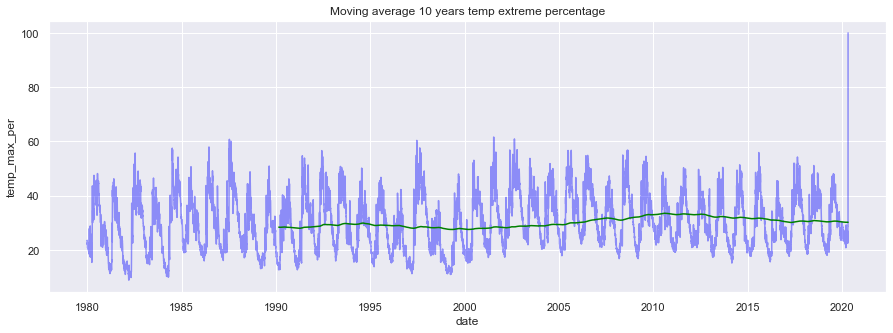

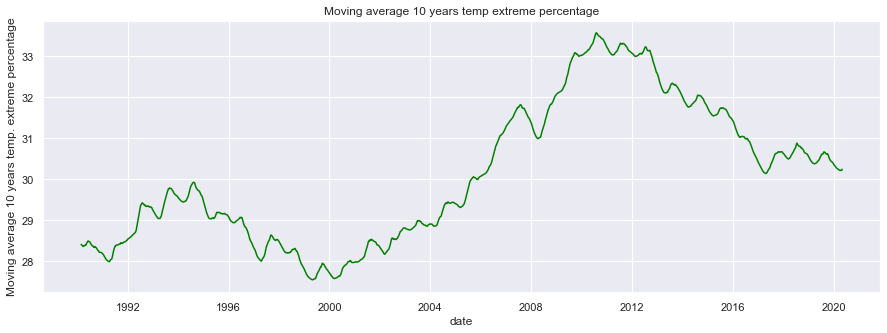

In [52]:
plt.figure(figsize=(15, 5))
sns.lineplot(flux_aggregated_3['date'], flux_aggregated_3['temp_max_per'], color = 'blue', alpha = 0.4)
sns.lineplot(flux_aggregated_3['date'], flux_aggregated_3["Moving average 10 years temp. extreme percentage"], color = 'green')
plt.title('Moving average 10 years temp extreme percentage')

plt.show()
plt.figure(figsize=(15, 5))
plt.title('Moving average 10 years temp extreme percentage')
sns.lineplot(flux_aggregated_3['date'], flux_aggregated_3["Moving average 10 years temp. extreme percentage"], color = 'green')
plt.show()

From the following graph is possible to conclude that the frequency of flux extreme have been decreasing since 2008. 

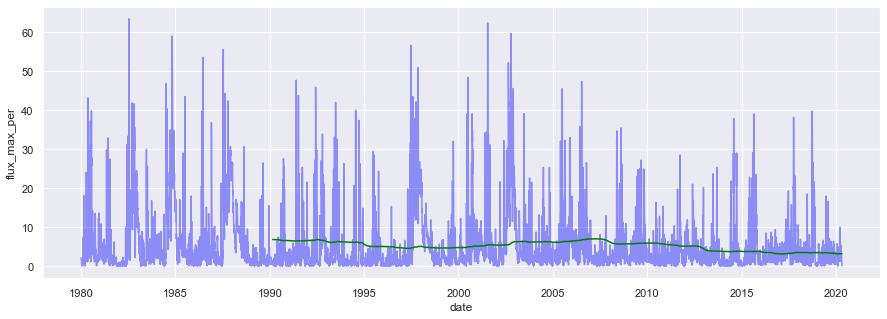

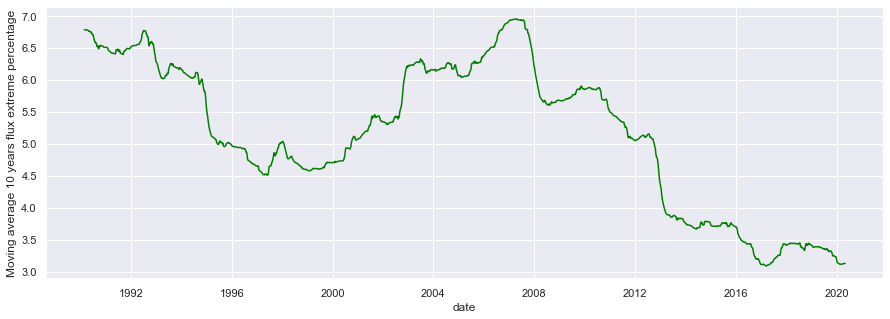

In [53]:
plt.figure(figsize=(15, 5))
sns.lineplot(flux_aggregated_3['date'], flux_aggregated_3['flux_max_per'], color = 'blue', alpha = 0.4)
sns.lineplot(flux_aggregated_3['date'], flux_aggregated_3["Moving average 10 years flux extreme percentage"], color = 'green')
plt.show()
plt.figure(figsize=(15, 5))
sns.lineplot(flux_aggregated_3['date'], flux_aggregated_3["Moving average 10 years flux extreme percentage"], color = 'green')
plt.show()

In conclusion, there are two periods 1) 1980 to 2000 and 2) 2000 to 2020, comparing the second period with the first period is possible to observe that the frequency of rain extreme have been decreasing, the frequency of temp extreme have been increasing and the frequency of flux extreme have been decreasing.

## Back to key questions

Some of the key questions we could try to answer are:

1. Has the frequency of heat waves events increased over the last years? $\newline$
2. Is there any relationship between heat waves and peak flow events? $\newline$
3. If so, can we correlate those events with the watershed's features? $\newline$

1. there are two periods 1) 1980 to 2000 and 2) 2000 to 2020, comparing the second period with the first in the following graph, is possible to observe that the frequency of heat waves have been increasing.

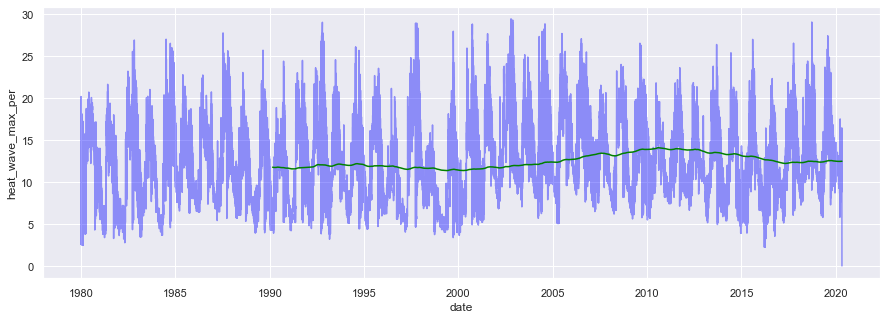

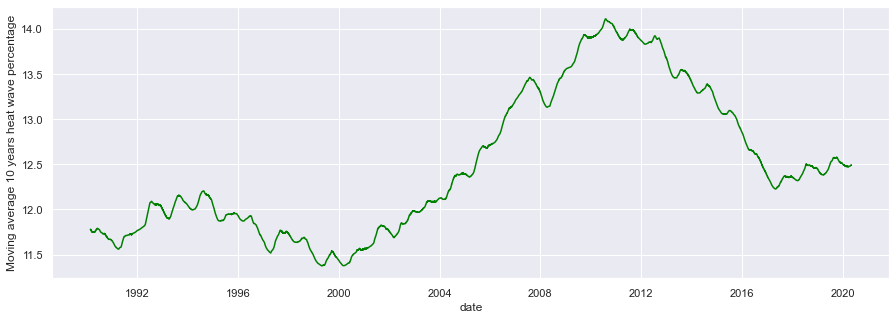

In [54]:
time_interval = 'date'

flux_aggregated_4 = flux_full.groupby([time_interval]).agg(
    precip_max = pd.NamedAgg(column = 'precip_extreme', aggfunc= 'sum'),
    temp_max = pd.NamedAgg(column = 'temp_extreme', aggfunc= 'sum'),
    flux_max = pd.NamedAgg(column = 'flux_extreme', aggfunc= 'sum'),
    heat_max = pd.NamedAgg(column = 'heat_wave', aggfunc= 'sum'),
    unique = pd.NamedAgg(column = 'unique', aggfunc= 'sum')
)

flux_aggregated_4['heat_wave_max_per'] = np.round(
    flux_aggregated_4['heat_max'] / flux_aggregated_4['unique'] * 100, 2
)

flux_aggregated_4.reset_index(inplace = True)
flux_aggregated_4.sort_values(by = 'date', inplace = True)

flux_aggregated_4["Moving average 10 years heat wave percentage"] = flux_aggregated_4['heat_wave_max_per'].rolling(7*53*10).mean()

plt.figure(figsize=(15, 5))
sns.lineplot(flux_aggregated_4['date'], flux_aggregated_4['heat_wave_max_per'], color = 'blue', alpha = 0.4)
sns.lineplot(flux_aggregated_4['date'], flux_aggregated_4["Moving average 10 years heat wave percentage"], color = 'green')
plt.show()
plt.figure(figsize=(15, 5))
sns.lineplot(flux_aggregated_4['date'], flux_aggregated_4["Moving average 10 years heat wave percentage"], color = 'green')
plt.show()

2. In the followin graph is possible to observe that the frequency of heat wave events and the frequency of flux extreme events are correlated.

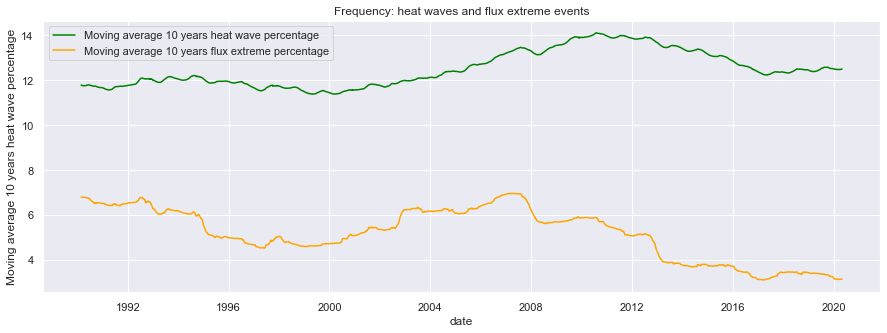

In [55]:
plt.figure(figsize=(15, 5))
sns.lineplot(flux_aggregated_4['date'], flux_aggregated_4["Moving average 10 years heat wave percentage"], color = 'green', label = "Moving average 10 years heat wave percentage")
sns.lineplot(flux_aggregated_3['date'], flux_aggregated_3["Moving average 10 years flux extreme percentage"], color = 'orange', label = 'Moving average 10 years flux extreme percentage')
plt.title('Frequency: heat waves and flux extreme events')
plt.show()

3. In the section 6 is observed that the frequency of events per month can be clustered and there are 3 main clusters. When looking the clusters in a map, they cluster centers are: extreme north, extreme south and rest of te country. In conclusion, there is correlation between the geographical charasteristics of a watershed and it's frequency of flux extreme, thereforo, there is also correlation between the geographical charasteristics and the frequency of heat waves. This analysis can be extended usin the altitud and area of a watershed.

## 7. Extreme flux prediction. 
Train one or many models (using your preferred algorithms) for estimating the probability of having an extreme flux. Feel free to create new features or use external variables. Some of the discussion we would like to see: Which data can be used and which cannot? Of course, we cannot use future data, but what about data from the same day? Or from the previous day?

Everything depends on how you propose the model use. Make a proposal on how you would use the model in practice (for example, once trained, the model will predict next day probability). Depending on your proposal, set constraints about which variables you can or cannot use.

Answer: 
$\newline$ 
My proposal is to build a model that estimate the probability of detecting a extreme flux in 1 day in advance and in 3 days in advance, per station. Ideally, the prediction in 1 day in advance will have a lower error than the second prediction.

$\newline$ 
The variables that capture the stations are max temperature and precipitation per day can be calculated when the day is over, so the information of the day t is available in t + 1 and is not possible to use information from the same day. In conclusion, to predict in day t for day t+1, there is data from the day t-1 and before. In this notebook I will develop a model to predict for the next day.

$\newline$ 
I proposed to train the model using all the available data from the years before 2019 to train and use year 2019 to test. Then this model will be used to predict in all the watersheds. 


$\newline$ 
I will use variables that:
1. Capture the behaviuor of the variables temp extreme and precip in the last t-1 days. It is because for predicting in the day t for the day t + 1, the last observation is from t - 1.
2. Cluster label of the watershed.
3. month of the observation.

The new variables are:
1. indicador if the last day was a flux extrem event
1. indicador if the last day was a temp extrem event
1. indicador if the last day was a precip extrem event

1. indicador if 2 fays ago was a flux extrem event
1. indicador if 2 fays ago was a temp extrem event
1. indicador if 2 fays ago was a precip extrem event

1. indicador if 3 fays ago was a flux extrem event
1. indicador if 3 fays ago was a temp extrem event
1. indicador if 3 fays ago was a precip extrem event

1. rolling average for 3, 7, 15, 30 and 45 days for the variables flux extrem, temp extrem, precip extrem, precip and temp_max.

In [56]:
flux_full.sort_values(by = 'date', inplace = True)
flux_full.reset_index(inplace = True, drop = True)

In [57]:
# Gest last observations
flux_full['flux_extreme_last_1'] = flux_full.groupby(['basin_id'])['flux_extreme'].shift(1)
flux_full['temp_extreme_last_1'] = flux_full.groupby(['basin_id'])['temp_extreme'].shift(1)
flux_full['precip_extreme_last_1'] = flux_full.groupby(['basin_id'])['precip_extreme'].shift(1)

flux_full['flux_extreme_last_2'] = flux_full.groupby(['basin_id'])['flux_extreme'].shift(2)
flux_full['temp_extreme_last_2'] = flux_full.groupby(['basin_id'])['temp_extreme'].shift(2)
flux_full['precip_extreme_last_2'] = flux_full.groupby(['basin_id'])['precip_extreme'].shift(2)

flux_full['flux_extreme_cont_2'] = flux_full.groupby(['basin_id'])['flux_extreme'].shift(1) * flux_full.groupby(['basin_id'])['flux_extreme'].shift(2)
flux_full['temp_extreme_cont_2'] = flux_full.groupby(['basin_id'])['temp_extreme'].shift(1) * flux_full.groupby(['basin_id'])['temp_extreme'].shift(2)
flux_full['precip_extreme_cont_2'] = flux_full.groupby(['basin_id'])['precip_extreme'].shift(1) * flux_full.groupby(['basin_id'])['temp_extreme'].shift(2)

flux_full['flux_extreme_cont_3'] = flux_full.groupby(['basin_id'])['flux_extreme'].shift(1) * flux_full.groupby(['basin_id'])['flux_extreme'].shift(2) * flux_full.groupby(['basin_id'])['flux_extreme'].shift(3)
flux_full['temp_extreme_cont_3'] = flux_full.groupby(['basin_id'])['temp_extreme'].shift(1) * flux_full.groupby(['basin_id'])['temp_extreme'].shift(2) * flux_full.groupby(['basin_id'])['temp_extreme'].shift(3)
flux_full['precip_extreme_cont_3'] = flux_full.groupby(['basin_id'])['precip_extreme'].shift(1) * flux_full.groupby(['basin_id'])['temp_extreme'].shift(2) * flux_full.groupby(['basin_id'])['temp_extreme'].shift(3)

flux_full['flux_extreme_rol_avg_3'] = flux_full.groupby(['basin_id'])['flux_extreme'].transform(lambda x: x.rolling(3, 1).mean())
flux_full['flux_extreme_rol_avg_7'] = flux_full.groupby(['basin_id'])['flux_extreme'].transform(lambda x: x.rolling(7, 1).mean())
flux_full['flux_extreme_rol_avg_15'] = flux_full.groupby(['basin_id'])['flux_extreme'].transform(lambda x: x.rolling(15, 1).mean())
flux_full['flux_extreme_rol_avg_30'] = flux_full.groupby(['basin_id'])['flux_extreme'].transform(lambda x: x.rolling(30, 1).mean())
flux_full['flux_extreme_rol_avg_45'] = flux_full.groupby(['basin_id'])['flux_extreme'].transform(lambda x: x.rolling(45, 1).mean())

flux_full['temp_extreme_rol_avg_3'] = flux_full.groupby(['basin_id'])['temp_extreme'].transform(lambda x: x.rolling(3, 1).mean())
flux_full['temp_extreme_rol_avg_7'] = flux_full.groupby(['basin_id'])['temp_extreme'].transform(lambda x: x.rolling(7, 1).mean())
flux_full['temp_extreme_rol_avg_15'] = flux_full.groupby(['basin_id'])['temp_extreme'].transform(lambda x: x.rolling(15, 1).mean())
flux_full['temp_extreme_rol_avg_30'] = flux_full.groupby(['basin_id'])['temp_extreme'].transform(lambda x: x.rolling(30, 1).mean())
flux_full['temp_extreme_rol_avg_45'] = flux_full.groupby(['basin_id'])['temp_extreme'].transform(lambda x: x.rolling(45, 1).mean())

flux_full['precip_extreme_rol_avg_3'] = flux_full.groupby(['basin_id'])['precip_extreme'].transform(lambda x: x.rolling(3, 1).mean())
flux_full['precip_extreme_rol_avg_7'] = flux_full.groupby(['basin_id'])['precip_extreme'].transform(lambda x: x.rolling(7, 1).mean())
flux_full['precip_extreme_rol_avg_15'] = flux_full.groupby(['basin_id'])['precip_extreme'].transform(lambda x: x.rolling(15, 1).mean())
flux_full['precip_extreme_rol_avg_30'] = flux_full.groupby(['basin_id'])['precip_extreme'].transform(lambda x: x.rolling(30, 1).mean())
flux_full['precip_extreme_rol_avg_45'] = flux_full.groupby(['basin_id'])['precip_extreme'].transform(lambda x: x.rolling(45, 1).mean())


flux_full['precip_rol_avg_3'] = flux_full.groupby(['basin_id'])['precip'].transform(lambda x: x.rolling(3, 1).mean())
flux_full['precip_rol_avg_7'] = flux_full.groupby(['basin_id'])['precip'].transform(lambda x: x.rolling(7, 1).mean())
flux_full['precip_rol_avg_15'] = flux_full.groupby(['basin_id'])['precip'].transform(lambda x: x.rolling(15, 1).mean())
flux_full['precip_rol_avg_30'] = flux_full.groupby(['basin_id'])['precip'].transform(lambda x: x.rolling(30, 1).mean())
flux_full['precip_rol_avg_45'] = flux_full.groupby(['basin_id'])['precip'].transform(lambda x: x.rolling(45, 1).mean())

flux_full['temp_rol_avg_3'] = flux_full.groupby(['basin_id'])['temp_max'].transform(lambda x: x.rolling(3, 1).mean())
flux_full['temp_rol_avg_7'] = flux_full.groupby(['basin_id'])['temp_max'].transform(lambda x: x.rolling(7, 1).mean())
flux_full['temp_rol_avg_15'] = flux_full.groupby(['basin_id'])['temp_max'].transform(lambda x: x.rolling(15, 1).mean())
flux_full['temp_rol_avg_30'] = flux_full.groupby(['basin_id'])['temp_max'].transform(lambda x: x.rolling(30, 1).mean())
flux_full['temp_rol_avg_45'] = flux_full.groupby(['basin_id'])['temp_max'].transform(lambda x: x.rolling(45, 1).mean())

In [58]:
flux_full.dropna(inplace = True, axis = 0)
flux_full.sort_values(by = 'date', inplace = True)

The training data is all the data available before 2018 and the test data is from the year 2918 and 2019. The year 2020 is excluded because of the different behaviour shown before and also because it has a very few observations.

In [59]:
flux_full_train = flux_full[(flux_full['date'] < '2018-01-01')]
flux_full_test = flux_full[(flux_full['date'] >= '2018-01-01') & (flux_full['date'] <= '2019-12-31')]

In [60]:
df_flux = []
for cod_station in flux_full_train['basin_id'].unique():
    for summer in flux_full_train['summer'].unique():
        df_cod = flux_full_train[(flux_full_train['basin_id'] == cod_station) & (flux_full_train['summer'] == summer)]
        treshold_flux = df_cod['flux'].quantile(0.95)
        treshold_precip = df_cod['precip'].quantile(0.95)
        treshold_temp_max = df_cod['temp_max'].quantile(0.95)
        df_cod['flux_extreme'] = (df_cod['flux'] > treshold_flux).astype(int)
        df_cod['temp_extreme'] = (df_cod['flux'] > treshold_temp_max).astype(int)
        df_cod['precip_extreme'] = (df_cod['flux'] > treshold_precip).astype(int)
        df_flux.append(df_cod)
    
flux_full_train = pd.concat(df_flux)
flux_full_train.reset_index(drop = True, inplace = True)

In [61]:
df_flux = []
for cod_station in flux_full_test['basin_id'].unique():
    for summer in flux_full_test['summer'].unique():
        df_cod = flux_full_test[(flux_full_test['basin_id'] == cod_station) & (flux_full_test['summer'] == summer)]
        treshold_flux = df_cod['flux'].quantile(0.95)
        treshold_precip = df_cod['precip'].quantile(0.95)
        treshold_temp_max = df_cod['temp_max'].quantile(0.95)
        df_cod['flux_extreme'] = (df_cod['flux'] > treshold_flux).astype(int)
        df_cod['temp_extreme'] = (df_cod['flux'] > treshold_temp_max).astype(int)
        df_cod['precip_extreme'] = (df_cod['flux'] > treshold_precip).astype(int)
        df_flux.append(df_cod)
    
flux_full_test = pd.concat(df_flux)
flux_full_test.reset_index(drop = True, inplace = True)

Separate data for test and train.

In [62]:
X_train = flux_full_train[['flux_extreme_last_1', 'temp_extreme_last_1',
                           'precip_extreme_last_1', 'flux_extreme_last_2',
                           'temp_extreme_last_2', 'precip_extreme_last_2',
                           'flux_extreme_cont_2', 'temp_extreme_cont_2',
                           'precip_extreme_cont_2','flux_extreme_cont_3',
                           'temp_extreme_cont_3', 'precip_extreme_cont_3',
                           'flux_extreme_rol_avg_3','flux_extreme_rol_avg_7',
                           'flux_extreme_rol_avg_15', 'flux_extreme_rol_avg_30',
                           'flux_extreme_rol_avg_45', 'temp_extreme_rol_avg_3', 
                           'temp_extreme_rol_avg_7', 'temp_extreme_rol_avg_15',
                           'temp_extreme_rol_avg_30', 'temp_extreme_rol_avg_45', 
                           'precip_extreme_rol_avg_3', 'precip_extreme_rol_avg_7',
                           'precip_extreme_rol_avg_15', 'precip_extreme_rol_avg_30',
                           'precip_extreme_rol_avg_45', 'precip_rol_avg_3',
                           'precip_rol_avg_7', 'precip_rol_avg_15', 'precip_rol_avg_30', 'precip_rol_avg_45', 
                           'temp_rol_avg_3', 'temp_rol_avg_7', 'temp_rol_avg_15', 'temp_rol_avg_30', 'temp_rol_avg_45',
                           'summer', 'month']]

X_train = pd.concat([X_train, pd.get_dummies(X_train['summer'], prefix='summer', drop_first = True)], axis=1)
X_train = pd.concat([X_train, pd.get_dummies(X_train['month'], prefix='month', drop_first = True)], axis=1)
# X_train.drop(['summer', 'month', 'labels'], inplace=True)

X_test = flux_full_test[['flux_extreme_last_1', 'temp_extreme_last_1',
                           'precip_extreme_last_1', 'flux_extreme_last_2',
                           'temp_extreme_last_2', 'precip_extreme_last_2',
                           'flux_extreme_cont_2', 'temp_extreme_cont_2',
                           'precip_extreme_cont_2','flux_extreme_cont_3',
                           'temp_extreme_cont_3', 'precip_extreme_cont_3',
                           'flux_extreme_rol_avg_3','flux_extreme_rol_avg_7',
                           'flux_extreme_rol_avg_15', 'flux_extreme_rol_avg_30',
                           'flux_extreme_rol_avg_45', 'temp_extreme_rol_avg_3', 
                           'temp_extreme_rol_avg_7', 'temp_extreme_rol_avg_15',
                           'temp_extreme_rol_avg_30', 'temp_extreme_rol_avg_45', 
                           'precip_extreme_rol_avg_3', 'precip_extreme_rol_avg_7',
                           'precip_extreme_rol_avg_15', 'precip_extreme_rol_avg_30',
                           'precip_extreme_rol_avg_45', 'precip_rol_avg_3',
                           'precip_rol_avg_7', 'precip_rol_avg_15', 'precip_rol_avg_30', 'precip_rol_avg_45', 
                           'temp_rol_avg_3', 'temp_rol_avg_7', 'temp_rol_avg_15', 'temp_rol_avg_30', 'temp_rol_avg_45',
                           'summer', 'month']]

X_test = pd.concat([X_test, pd.get_dummies(X_test['summer'], prefix='summer', drop_first = True)], axis=1)
X_test = pd.concat([X_test, pd.get_dummies(X_test['month'], prefix='month', drop_first = True)], axis=1)
# X_test.drop(['summer', 'month', 'labels'], inplace=True)

In [63]:
y_train = flux_full_train[['flux_extreme']]
y_test = flux_full_test[['flux_extreme']]

Trainning the model.

In [64]:
params = {'num_leaves': 555,
          'min_child_weight': 0.0034,
          'feature_fraction': 0.379,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 10,
          'objective': 'regression',
          'max_depth': -1,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'rmse',
          "verbosity": -1,
          'reg_alpha': 0.3899,
          'reg_lambda': 0.648,
          'random_state': 222,
         }

The training error methos is RMSE, it useful to detect how close are the predicted values in comparison with the real values.

[1]	valid_0's rmse: 0.216481
[2]	valid_0's rmse: 0.216273
[3]	valid_0's rmse: 0.215866
[4]	valid_0's rmse: 0.215536
[5]	valid_0's rmse: 0.215296
[6]	valid_0's rmse: 0.215046
[7]	valid_0's rmse: 0.214881
[8]	valid_0's rmse: 0.214658
[9]	valid_0's rmse: 0.214406
[10]	valid_0's rmse: 0.214168
[11]	valid_0's rmse: 0.213895
[12]	valid_0's rmse: 0.213545
[13]	valid_0's rmse: 0.213347
[14]	valid_0's rmse: 0.213039
[15]	valid_0's rmse: 0.212818
[16]	valid_0's rmse: 0.212477
[17]	valid_0's rmse: 0.21215
[18]	valid_0's rmse: 0.211827
[19]	valid_0's rmse: 0.211488
[20]	valid_0's rmse: 0.211275
[21]	valid_0's rmse: 0.211064
[22]	valid_0's rmse: 0.210809
[23]	valid_0's rmse: 0.210463
[24]	valid_0's rmse: 0.210204
[25]	valid_0's rmse: 0.209977
[26]	valid_0's rmse: 0.209866
[27]	valid_0's rmse: 0.209591
[28]	valid_0's rmse: 0.209314
[29]	valid_0's rmse: 0.20901
[30]	valid_0's rmse: 0.208738
[31]	valid_0's rmse: 0.208514
[32]	valid_0's rmse: 0.208304
[33]	valid_0's rmse: 0.208004
[34]	valid_0's rmse: 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

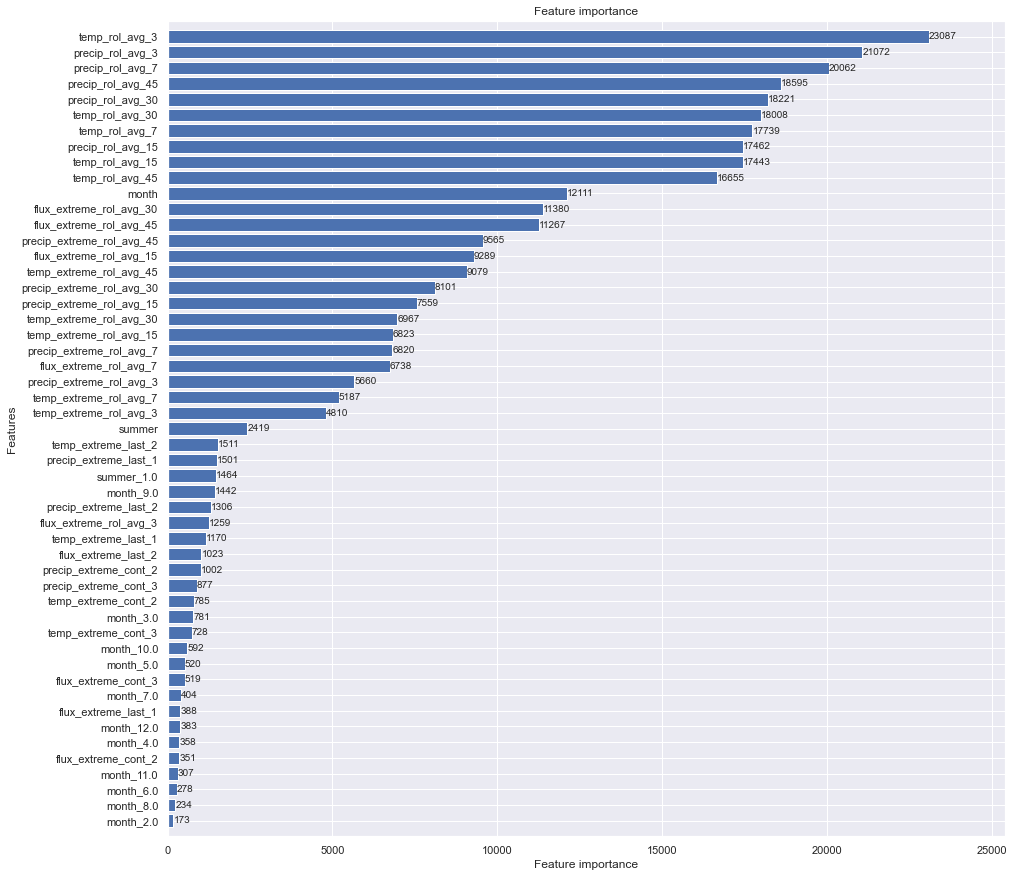

In [69]:
# laoding data
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 num_boost_round=600,)

# prediction
y_pred = model.predict(X_test)

# accuracy check
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

# plotting feature importance
lgb.plot_importance(model, height=.8, figsize=(15, 15)) 

## 8. Analyze the model results.

1. What is the performance of the model? Which metrics you consider are the best suited for this problem? What are the most important variables? What do you think about the results?
2. If we wanted to identify at least 70% of the extreme flux events, which are the metrics of your model for that threshold? It is a useful model?

Answer:
$\newline$
1. As the objectivo of the model is to predict extreme values, that are 5% of the data, is necesarry to be careful when chosing the metric, because the model can have a high accuaracy by just assigning every value to 0. Therefore, I consider the best metrics for this problem are the F1 score and the precission, because these metric are sensitive to the issue mentioned before.

The model have a medium F1 score, but a 67% of precision score, wich means that discriminate correctly in a 67% of the total cases.
$\newline$

I think the model have an acceptable precision_score and also a high roc_auc_score. This model is a baseline, there are oportunities to study more the data, create new variables, study tendency and train the model in different ways. I think the model can be impruve significantly.

In [70]:
y_pred_2 = (y_pred > 0.5).astype(int)

f1_score(y_test, y_pred_2), precision_score(y_test, y_pred_2)

(0.4921893491124261, 0.6718901453957997)

In [71]:
roc_auc_score(y_test, y_pred_2)

0.6892331887433449

2. It is possible to study the next metric: true_assigned / true_postive. The value of this metrix is 39%. Is not useful to predict at least the 70% of flux extreme cases, but as I said, is a base line, and there is a lot to do here! :D

In [72]:
cf = confusion_matrix(y_test, y_pred_2)
(cf[1][1] / cf[1].sum()) * 100

38.83286647992531

Thank you!